# General notes 

This jupyter notebook is intended to work on the two day spectroscopic subsample. In particular, we want to target those with a first spectrum with SEDm to decide on the quality of the spectrum to identify flash ionisation features. 

Within our sample, a few candidates had their first spectra obtained with SEDm. We try to identify those whose first spectrum is not scientifically viable yto asses the presence of flash features. 

The discrimination is based on the SNR of the spectrum, for a bandpass in g band. 

In [1]:
ls

22jww_1405.ascii
LT_weakflash.eps
LT_weakflash.pdf
SEDm_strongflash.eps
SEDm_weakfkash.eps
SNR_estimates_for_telescopes.ipynb
Spectroscopic Analysis 2d Subsample (Saturn.local's conflicted copy 2022-06-06).ipynb
Spectroscopic Analysis 2d Subsample.ipynb
TNG_weakflash.eps
TNG_weakflash.pdf
ZTF18abojpnr/
ZTF18acqwdla/
ZTF19aarfkch/
ZTF19aatqzrb/
ZTF19abbwfgp/
ZTF19abjioie/
ZTF19abpidqn/
ZTF19abrlvij/
ZTF19acctwpz/
ZTF20aasfhia/
ZTF20abybeex/
ZTF20acknpig/
ZTF20acuaqlf/
ZTF20acwgxhk/
__pycache__/
blablajwww.ascii
cadia.ascii
fitter_full_code_def.py
hgspec_targetsnonly_crr_b_ifu20220425_11_13_21_ZTF22aahhgjh.txt
lines_library.py
main.py


In [2]:
pwd

'/Users/r.saturn/Dropbox (Weizmann Institute)/PhD/WIP/Full_RISNeII_ZTF1/2dSS_SEDm_analysis'

In [1]:
import numpy as np
from astropy.io import ascii
import matplotlib.pylab as plt
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import os
import math
from astropy.table import vstack, Table, hstack
import extinction
import sfdmap
from astropy.coordinates import SkyCoord
import scipy
from fitter_full_code_def import *
from astropy.coordinates import SkyCoord  # High-level coordinates
import sfdmap 
from PyAstronomy import pyasl
from specutils.analysis import snr
from specutils import Spectrum1D
import astropy.units as u
from PyAstronomy import pyasl

In [2]:
from matplotlib import rc

rc('font', **{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

plt.rcParams['xtick.labelsize']=18
plt.rcParams['ytick.labelsize']=18


In [3]:
%matplotlib notebook

In [4]:
def correct_spectrum(name,spectrum):
    '''
    
    this functiuon corrects the spectrum for extinction and redshift. 
    DO NOT correct prior to SNR estimation (??)
    
    paramters
    ---------
    name     [string] ZTF name of the candidate
    spectrum [table] spectrum 
    
    returns
    -------
    spectrum [table] redshift corrected and extinction corrected
    
    WARNING
    -------
    the varaiable "table_infants" is global and has to be defined prior to the use of this function ... 
    
    
    '''

    tab =  table_infants[table_infants['name']==name]

    z   = tab['redshift'][0]
    co  = SkyCoord (np.array(tab['ra_med'][0]),np.array(tab['dec_med'][0]),unit = 'deg', frame = 'fk5') 


    gal_reddening   = sfdmap.SFDMap('/Volumes/Machiavelli/code_library/python/sfddata-master/', scaling=0.86)
    EBV             = gal_reddening.ebv(co)

#     spectrum        = spectrum[(spectrum['wl']>=4000)&(spectrum['wl']<=8000)]

    spectrum['flux']  = pyasl.unred(spectrum['wl'], spectrum['flux'], EBV)

    #redshift correction
    spectrum['wl']    = spectrum['wl']/(z+1) 
    
    return spectrum



In [5]:
def estimate_snr_over_band(spec, bandpass = [5000,6000], is_var = False):
    '''
    this function estimates the SNR of a spectrum over a specified bandpass
    we assume that your table is ['wl','flux','var']
    
    parameters
    ---------
    spec     [table]
    bandpass [list]
    
    returns
    -------
    snr [float]
    '''
    if is_var is False:
        std            = np.std(spec[(spec.columns[0]>=bandpass[0])
                                           &(spec.columns[0]<=bandpass[-1])].columns[1])
        
        signal_portion = spec[(spec.columns[0]>=bandpass[0])
                                     &(spec.columns[0]<=bandpass[-1])].columns[1]
        
        return np.nanmedian(signal_portion/std)
        
    elif is_var is True:
        
        signal_portion = spec[(spec.columns[0]>=bandpass[0])
                                     &(spec.columns[0]<=bandpass[-1])]
       
        return np.nanmedian(signal_portion.columns[1]/np.sqrt(signal_portion.columns[2]))

    

In [6]:

def bin_spectra(wl, flux, resolution, method = 'mean'):
    '''
    this function bins the input spectrum
    
    parameters
    ----------
    wl [array or list] wavelength
    fluc [array or list] flux array
    resolution size of the wavelength bean 
    method [string] -optional- take the mean or the median in the binsize

    returns
    -------
    astropy table of the binned spec and mean flux in bin
    '''

    number_of_bins = math.floor((wl[-1]-wl[0]) / resolution )   #say we want it every 10 nanometers
    print(number_of_bins) 

    #performs the data rebinning by taking the beam of the fluc value inside the bin
    stat, bin_edge, inde = scipy.stats.binned_statistic(wl, flux, statistic=method, bins = number_of_bins)

    #print(bin_edge)
    #print(stat)

    #takes the mean of the edges of the bin in order to plot the binned spectrum

    bin_wavelength =  [ (bin_edge[i]+ bin_edge[i+1])/2 for i in range(len(bin_edge)-1) ]

    bin_spectra = Table()
    bin_spectra['bin_wl']   = bin_wavelength
    bin_spectra['bin_flux'] = stat

    print('the spectra is binned for a resolution of', resolution)
    return bin_spectra

In [7]:
def noise_spec(snr, spec, bandpass = [5900,6300]):
    '''
    This function

    
    parameters
    ----------
    SNR 
    spectrum (flux)
    bandpass [list] bandpass for estimating the mean of the spectrum
    
    returns
    -------
    noised flux [array]
    
    '''   
    
    flux  = spec['bin_flux']
    

    mean_flux = np.average( spec[(spec['bin_wl']>=bandpass[0])&(spec['bin_wl']<=bandpass[-1])]['bin_flux'] )
    
    # Generate an sample of white noise
    sigma_noise =  mean_flux/snr
    
    mean_noise = 0
    noise      = np.random.normal(mean_noise, sigma_noise, len(flux))
        
    # Noise up the original signal
    noised_flux = flux + noise
    
    return noised_flux
    
    



In [8]:
# table_infants  = ascii.read('/Users/r.saturn/PhD/WIP/Full_RISNeII_ZTF1/tables/RISNeIIfull_radeczeztexpflash_22122021.csv')
table_infants  = ascii.read('/Users/r.saturn/Dropbox (Weizmann Institute)/PhD/WIP/Full_RISNeII_ZTF1/tables/RISNeIIfull_radeczeztexpflashpeakclimb_15022022.csv')



In [9]:
np.unique(table_infants['rach-classification'])

SN II
SN II-bump
SN II-pec
SN IIb
SN IIn


In [10]:
subsamp2d = table_infants[(table_infants['Fs-Texp']<=2.)]

In [11]:
subsamp2d

name,rach-classification,Flasher,classification,First Detection,Last Non Detection,First Spectrum,instrument-fs,fD-lND,fS-lND,ra_med,dec_med,redshift,e_redshift,z_ref,jd-redshift,instrument-redshift,UV,host,host_type,P-cygni,jd-pcyg,instrument-pcyg,t_exp,e_t_exp,jd_t_exp,Fs-Texp,peakabsmag_r,e_peakabsmag_r,peakday_r,e_peakday_r,peakabsmag_g,e_peakabsmag_g,peakday_g,e_peakday_g,decline_r,e_decline_r,decline_g,e_decline_g,climb_time_r,climb_time_g
str12,str10,str4,str6,float64,float64,float64,str11,float64,float64,float64,float64,float64,float64,str69,float64,str11,str4,str4,str12,str4,float64,str11,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
ZTF18abckutn,SN II,no,SN IIP,2458289.865,2458289.758,2458290.748,DBSP+P200,0.1074884,0.99028249,237.026897,55.7148553,0.040705,0.000123,1999PASP..111..438F,--,--,yes,yes,notype,yes,2458307.69,DBSP+P200,-0.1069391354,0.01501290292,2458289.758,0.98993913,-17.489833262081575,0.00961684735079223,16.19256326104363,0.29419405502410373,-17.511123656906882,0.014952041887626596,9.522573088435623,0.6234607506231766,0.008576205724715288,0.001859420359141762,0.029699745465459428,0.0059168450289302996,9.330205161421391,6.232506273806587
ZTF18abdbysy,SN II,yes?,SN IIP,2458295.705,2458294.781,2458296.4,ACAM+WHT,0.9234606,1.6180685,233.535367,56.6968577,0.012122,0.000175,2005SDSS4.C...0000:,--,--,yes,yes,notype,yes,2458334.75,DBSP+P200,-0.9810973016,0.001930022149,2458294.724,1.6760973,-15.49331020545953,0.0331526327068752,16.85753795836716,0.2862893468098687,-14.505103984137875,0.03272188124838144,10.372182527968567,0.3033303606071478,0.011610440903574113,0.0013302220278154035,0.03011464940724035,0.007192822166535693,10.821940937539091,7.09928796409179
ZTF18abeajml,SN II,yes,SN II,2458303.799,2458302.797,2458304.794,SEDm+P60,1.0019,1.99674769,252.03236,24.3040949,0.036526,8.6e-05,2005SDSS4.C...0000:,--,--,yes,yes,notype,yes,2458331.71,SEDm+P60,-0.02632267313,1.331885814,2458303.773,1.02132267,-18.50264443512861,0.015414958320710454,10.42687184147541,1.5013246095658397,-18.549787640366937,0.007498228090990184,7.372101208620604,1.351557480278869,0.0204867406038592,0.0009898916851182882,0.03619533929041421,0.0026608903799914055,6.572604715042432,4.575926693168947
ZTF18abffyqp,SN IIb,yes,SN IIb,2458307.686,2458306.822,2458307.85,DBSP+P200,0.8641,1.02749037,252.708677,45.3978958,0.031302,0.000157,1999PASP..111..438F,--,--,yes,yes,Sb,yes,2458432.716,LRIS+Keck,-0.432,0.432,2458307.254,0.596,-17.609854491274334,0.011990614229031015,2.66015859070649,0.4325518211604079,-17.758296472114907,0.015570650276522859,1.7225091037268083,0.4416819275725578,99.0,99.0,99.0,99.0,99.0,99.0
ZTF18abgqvwv,SN II,yes?,SN IIP,2458313.73,2458312.838,2458314.569,ISIS+WHT,0.8915,1.73143,254.316401,31.9631992,0.037726,9.7e-05,2004SDSS3.C...0000:,--,--,no,yes,notype,yes,2458351.82,DBSP+P200,-1.02018285,0.001249450749,2458312.71,1.85918285,-16.814019840514156,0.006961016565343625,16.7395086276049,0.780814570522296,-16.656944283657296,0.030287354900355737,5.723185790692419,0.6022522133450261,-0.002767699609499243,0.0017236495965795575,0.0069464632463789545,0.0022731549446064706,14.424816825463473,4.47988680579762
ZTF18abojpnr,SN IIb,no,SN IIb,2458351.659,2458350.934,2458351.897,SEDm+P60,0.7244907,0.9628849,297.487196,59.5927746,0.03746898569,0.0002620246407,meas,2458638.051,DBSP+P200,no,yes,--,yes?,2458374.0,DBSP+P200,-0.7239549087,0.002526066554,2458350.935,0.96195491,-17.63030220457361,0.024003459682283464,21.40574400752213,0.7111580069198933,-17.333900653194725,0.02564558406295755,17.80400339133716,0.8112155070327837,99.0,99.0,99.0,99.0,99.0,99.0
ZTF18abokyfk,SN II,yes,SN II,2458350.89,2458349.901,2458352.006,DBSP+P200,0.9891898,2.10471592,2.360629,47.3540827,0.017189,3.3e-05,1999ApJS..121..287H,--,--,yes,yes,Sbc,yes,2458470.335,ACAM+WHT,-0.01311684685,0.00810257263,2458350.877,1.12911685,-17.17781792076166,0.008184648340751678,14.129301377

In [12]:
twoday_subsampSNII = subsamp2d[subsamp2d['rach-classification']=='SN II']

twoday_subsamOTHER = subsamp2d[subsamp2d['rach-classification']!='SN II']

In [13]:
twoday_subsampSNII.show_in_notebook()

idx,name,rach-classification,Flasher,classification,First Detection,Last Non Detection,First Spectrum,instrument-fs,fD-lND,fS-lND,ra_med,dec_med,redshift,e_redshift,z_ref,jd-redshift,instrument-redshift,UV,host,host_type,P-cygni,jd-pcyg,instrument-pcyg,t_exp,e_t_exp,jd_t_exp,Fs-Texp,peakabsmag_r,e_peakabsmag_r,peakday_r,e_peakday_r,peakabsmag_g,e_peakabsmag_g,peakday_g,e_peakday_g,decline_r,e_decline_r,decline_g,e_decline_g,climb_time_r,climb_time_g
0,ZTF18abckutn,SN II,no,SN IIP,2458289.865,2458289.758,2458290.748,DBSP+P200,0.1074884,0.99028249,237.026897,55.7148553,0.040705,0.000123,1999PASP..111..438F,--,--,yes,yes,notype,yes,2458307.69,DBSP+P200,-0.1069391354,0.01501290292,2458289.758,0.98993913,-17.489833262081575,0.00961684735079223,16.19256326104363,0.29419405502410373,-17.511123656906882,0.014952041887626596,9.522573088435623,0.6234607506231766,0.008576205724715288,0.001859420359141762,0.029699745465459428,0.0059168450289302996,9.330205161421391,6.232506273806587
1,ZTF18abdbysy,SN II,yes?,SN IIP,2458295.705,2458294.781,2458296.4,ACAM+WHT,0.9234606,1.6180685,233.535367,56.6968577,0.012122,0.000175,2005SDSS4.C...0000:,--,--,yes,yes,notype,yes,2458334.75,DBSP+P200,-0.9810973016,0.001930022149,2458294.724,1.6760973,-15.49331020545953,0.0331526327068752,16.85753795836716,0.2862893468098687,-14.505103984137875,0.03272188124838144,10.372182527968567,0.3033303606071478,0.011610440903574113,0.0013302220278154035,0.03011464940724035,0.007192822166535693,10.821940937539091,7.09928796409179
2,ZTF18abeajml,SN II,yes,SN II,2458303.799,2458302.797,2458304.794,SEDm+P60,1.0019,1.99674769,252.03236,24.3040949,0.036526,8.6e-05,2005SDSS4.C...0000:,--,--,yes,yes,notype,yes,2458331.71,SEDm+P60,-0.02632267313,1.331885814,2458303.773,1.02132267,-18.50264443512861,0.015414958320710454,10.42687184147541,1.5013246095658397,-18.549787640366937,0.007498228090990184,7.372101208620604,1.351557480278869,0.0204867406038592,0.0009898916851182882,0.03619533929041421,0.0026608903799914055,6.572604715042432,4.575926693168947
3,ZTF18abgqvwv,SN II,yes?,SN IIP,2458313.73,2458312.838,2458314.569,ISIS+WHT,0.8915,1.73143,254.316401,31.9631992,0.037726,9.7e-05,2004SDSS3.C...0000:,--,--,no,yes,notype,yes,2458351.82,DBSP+P200,-1.02018285,0.001249450749,2458312.71,1.85918285,-16.814019840514156,0.006961016565343625,16.7395086276049,0.780814570522296,-16.656944283657296,0.030287354900355737,5.723185790692419,0.6022522133450261,-0.002767699609499243,0.0017236495965795575,0.0069464632463789545,0.0022731549446064706,14.424816825463473,4.47988680579762
4,ZTF18abokyfk,SN II,yes,SN II,2458350.89,2458349.901,2458352.006,DBSP+P200,0.9891898,2.10471592,2.360629,47.3540827,0.017189,3.3e-05,1999ApJS..121..287H,--,--,yes,yes,Sbc,yes,2458470.335,ACAM+WHT,-0.01311684685,0.00810257263,2458350.877,1.12911685,-17.17781792076166,0.008184648340751678,14.129301377718392,1.0319524497021388,-17.01907663711989,0.0332647297080407,10.042441351563802,1.685214752840058,0.005844303818708419,0.0014540596351276867,0.026480640502759393,0.0014649410130147898,10.31568752100516,6.276399839859646
5,ZTF18abwlsoi,SN II,yes,SN II,2458377.63,2458376.74,2458377.751,SEDm+P60,0.8952,1.0131723,261.897614,71.530251,0.05376479944,0.007318710553,meas,2458443.6,SEDm+P60,no,yes,--,yes,2458443.6,SEDm+P60,-0.02146235453,0.002665623404,2458377.609,0.14246235,-18.518220748706636,0.29569547023108217,6.291511375496778,0.3851094457398963,-18.581476347170103,0.2963036637351274,4.884686383300792,0.285709373570058,0.031614797151004376,0.008121157616170814,0.045954074587724325,0.007425436176296284,4.868515110202693,3.165895028481702
6,ZTF18acqwdla,SN II,no,SN II,2458443.874,2458443.789,2458443.937,SEDm+P60,0.0855324,0.1481347,106.472662,12.8929375,0.026212141,0.004739291488,meas,2458616.456,EFOSC2+NTT,no,yes,--,yes,2458616.456,EFOSC2+NTT,-0.04249999998,0.04249999998,2458443.832,0.1055,-18.60137684700958,0.39262836644613214,12.183829851753528,1.2991954919750475,-18.754296156407,0.39288470141123233,11.513745758265994,0.385908

In [14]:
twoday_subsamOTHER.show_in_notebook()

idx,name,rach-classification,Flasher,classification,First Detection,Last Non Detection,First Spectrum,instrument-fs,fD-lND,fS-lND,ra_med,dec_med,redshift,e_redshift,z_ref,jd-redshift,instrument-redshift,UV,host,host_type,P-cygni,jd-pcyg,instrument-pcyg,t_exp,e_t_exp,jd_t_exp,Fs-Texp,peakabsmag_r,e_peakabsmag_r,peakday_r,e_peakday_r,peakabsmag_g,e_peakabsmag_g,peakday_g,e_peakday_g,decline_r,e_decline_r,decline_g,e_decline_g,climb_time_r,climb_time_g
0,ZTF18abffyqp,SN IIb,yes,SN IIb,2458307.686,2458306.822,2458307.85,DBSP+P200,0.8641,1.02749037,252.708677,45.3978958,0.031302,0.000157,1999PASP..111..438F,--,--,yes,yes,Sb,yes,2458432.716,LRIS+Keck,-0.432,0.432,2458307.254,0.596,-17.609854491274334,0.011990614229031015,2.66015859070649,0.4325518211604079,-17.758296472114907,0.015570650276522859,1.7225091037268083,0.4416819275725578,99.0,99.0,99.0,99.0,99.0,99.0
1,ZTF18abojpnr,SN IIb,no,SN IIb,2458351.659,2458350.934,2458351.897,SEDm+P60,0.7244907,0.9628849,297.487196,59.5927746,0.03746898569,0.0002620246407,meas,2458638.051,DBSP+P200,no,yes,--,yes?,2458374.0,DBSP+P200,-0.7239549087,0.002526066554,2458350.935,0.96195491,-17.63030220457361,0.024003459682283464,21.40574400752213,0.7111580069198933,-17.333900653194725,0.02564558406295755,17.80400339133716,0.8112155070327837,99.0,99.0,99.0,99.0,99.0,99.0
2,ZTF19aarfkch,SN IIb,no,SN IIb,2458592.68,2458591.92,2458593.848,SEDm+P60,0.7607,1.924202,221.131644,70.4559895,0.05083223351,0.001573010477,meas,2458666.881,LRIS+Keck,no,yes,--,no?,2458666.881,LRIS+Keck,-0.015033092,0.01301668502,2458592.665,1.18303309,-18.203336048326214,0.07001077894632139,6.945792430635295,0.5362816653949717,-18.061406123189087,0.06892036949631188,4.388580008672213,0.19270696371452656,99.0,99.0,99.0,99.0,99.0,99.0
3,ZTF19aatesgp,SN IIb,yes,SN IIb,2458602.785,2458601.785,2458603.759,KAST+Lick,0.9998,1.97448657,185.733956,15.826127,0.00524,3e-06,1995AJ....109.2444R,--,--,yes,yes,SAB(s)bc,no?,2458637.897,LRIS+Keck,-0.5,0.5,2458602.285,1.474,-15.904912318389998,0.004110942900316666,12.563278010505352,0.5214985605500098,-14.691858207341188,0.02994352711808812,11.25010475801597,0.502322886822422,99.0,99.0,99.0,99.0,99.0,99.0
4,ZTF19abpidqn,SN IIn,no,SN IIn,2458707.713,2458706.892,2458708.858,SEDm+P60,0.8206713,1.9661608,304.988297,15.3774528,0.01458,0.000117,1999ApJS..121..287H,--,--,yes,yes,notype,no,2458733.85,DBSP+P200,-0.004695514956,0.06671302385,2458707.708,1.14969551,-16.388068758996756,0.019074496914229844,8.56151852054244,0.37133437192920543,-16.484725875781635,0.022854667803874067,7.239446196376228,0.5346613564569079,99.0,99.0,99.0,99.0,99.0,99.0
5,ZTF19acctwpz,SN IIb,no,SN II,2458761.65,2458760.68,2458762.733,SEDm+P60,0.9703,2.0558419,2.691207,21.1390942,0.02941194307,0.0009348666691,meas,2458822.527,EFOSC2+NTT,yes,yes,--,yes?,--,--,-0.4849999999,0.4849999999,2458761.165,1.568,-17.59002228543016,0.06918973887739087,2.043955096417255,0.5141695181627108,-17.786565313510174,0.07672239259535964,1.7222920315737404,0.5053932503410905,99.0,99.0,99.0,99.0,99.0,99.0
6,ZTF20abwzqzo,SN IIb,no,SN IIb,2459087.947,2459086.983,2459088.043,GMOS+Gemini,0.9644,1.06037745,41.5138221,3.329908,0.023033,0.000103,1999ApJS..121..287H,--,--,yes,yes,--,yes,2459106.66,ALFOSC+NOT,-0.4820000003,0.4820000001,2459087.465,0.578,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0


What am I asking this sample: 

At which magnitude would I stop seeing flash features with SEDm? (or rather, how bright does the target need to be so that SEDm could have detected flash features. )
Should it be based on weak flash features? 




In [15]:
twoday_subsampSNII[twoday_subsampSNII['instrument-fs']=='SEDm+P60']

name,rach-classification,Flasher,classification,First Detection,Last Non Detection,First Spectrum,instrument-fs,fD-lND,fS-lND,ra_med,dec_med,redshift,e_redshift,z_ref,jd-redshift,instrument-redshift,UV,host,host_type,P-cygni,jd-pcyg,instrument-pcyg,t_exp,e_t_exp,jd_t_exp,Fs-Texp,peakabsmag_r,e_peakabsmag_r,peakday_r,e_peakday_r,peakabsmag_g,e_peakabsmag_g,peakday_g,e_peakday_g,decline_r,e_decline_r,decline_g,e_decline_g,climb_time_r,climb_time_g
str12,str10,str4,str6,float64,float64,float64,str11,float64,float64,float64,float64,float64,float64,str69,float64,str11,str4,str4,str12,str4,float64,str11,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
ZTF18abeajml,SN II,yes,SN II,2458303.799,2458302.797,2458304.794,SEDm+P60,1.0019,1.99674769,252.03236,24.3040949,0.036526,8.6e-05,2005SDSS4.C...0000:,--,--,yes,yes,notype,yes,2458331.71,SEDm+P60,-0.02632267313,1.331885814,2458303.773,1.02132267,-18.50264443512861,0.015414958320710454,10.42687184147541,1.5013246095658397,-18.549787640366937,0.007498228090990184,7.372101208620604,1.351557480278869,0.0204867406038592,0.0009898916851182882,0.03619533929041421,0.0026608903799914055,6.572604715042432,4.575926693168947
ZTF18abwlsoi,SN II,yes,SN II,2458377.63,2458376.74,2458377.751,SEDm+P60,0.8952,1.0131723,261.897614,71.530251,0.05376479944,0.007318710553,meas,2458443.6,SEDm+P60,no,yes,--,yes,2458443.6,SEDm+P60,-0.02146235453,0.002665623404,2458377.609,0.14246235,-18.518220748706636,0.29569547023108217,6.291511375496778,0.3851094457398963,-18.581476347170103,0.2963036637351274,4.884686383300792,0.285709373570058,0.031614797151004376,0.008121157616170814,0.045954074587724325,0.007425436176296284,4.868515110202693,3.165895028481702
ZTF18acqwdla,SN II,no,SN II,2458443.874,2458443.789,2458443.937,SEDm+P60,0.0855324,0.1481347,106.472662,12.8929375,0.026212141,0.004739291488,meas,2458616.456,EFOSC2+NTT,no,yes,--,yes,2458616.456,EFOSC2+NTT,-0.04249999998,0.04249999998,2458443.832,0.1055,-18.60137684700958,0.39262836644613214,12.183829851753528,1.2991954919750475,-18.754296156407,0.39288470141123233,11.513745758265994,0.38590822695090043,0.01596825397963348,0.0006413914572852468,0.03923859349765954,0.0008299446480697324,99.0,99.0
ZTF19aatqzrb,SN II,no,SN II,2458606.799,2458605.888,2458607.87,SEDm+P60,0.9103588,1.9821106,221.652383,56.2342197,0.038136,9e-05,1988AJ.....95.1602S,--,--,no,yes,notype,no?,2458616.902,DBSP+P200,-0.01225465929,0.002565603556,2458606.787,1.08325466,-17.203746852930166,0.013660957745520251,17.561061757168286,0.729005380149389,-16.97636231923359,0.01592565259282788,10.330295126430208,0.9424960372674184,0.010127175501533262,0.0026255683466046543,0.02635034078202941,0.003927785695777718,13.29031357816509,5.845258530462861
ZTF19abbwfgp,SN II,no,SN IIP,2458661.82,2458660.843,2458663.759,SEDm+P60,0.9774,2.9160862,258.323795,43.7843194,0.025925,0.000117,1996AJ....112.1803M,--,--,no,yes,notype,yes,2458765.626,SEDm+P60,-0.003414843865,3.554028127,2458661.817,1.94241484,-18.186342251238855,0.014048037207915394,16.568761702761094,3.902908966038234,-18.320690934249058,0.012077415898528105,10.069203091028774,3.5684189048473307,0.010489959256260756,0.0008571756329513857,0.026363764932218915,0.0018966819703930445,8.963188294655511,6.870977314482737
ZTF19abqhobb,SN II,yes,SN II,2458714.663,2458713.742,2458714.792,SEDm+P60,0.9213,1.0508631,261.4111,59.4467303,0.01815,1e-05,2006AJ....132..231P,--,--,yes,yes,Scd( f ),yes,2458878.71,ALFOSC+NOT,-0.0379833268,0.00608132416,2458714.625,0.16698333,-17.64125267005545,0.00866796071694527,8.582697522693397,0.5669372272342655,-17.465368004847953,0.019635823367565336,7.682337884769271,1.2202711183018025,0.010103578145785736,0.0007073497740846882,0.02204664496274497,0.0014619438297216788,7.833160915760206,4.327674459143019
ZTF19abrlvij,SN II,no,SN II,2458719.65,2458718.81,2458719.863,SEDm+P60,0.8405,1.0517319,260.142987,51.6327799,0.04737034239,0.001434140161,mea

In [16]:
# ascii.write(twoday_subsampSNII,'/Users/r.saturn/PhD/WIP/Full_RISNeII_ZTF1/tables/RISNeII2dsubsamp_gband_magatFS_16032022.csv')

In [16]:
twoday_SNII_noflash = twoday_subsampSNII[(twoday_subsampSNII['Flasher']=='no')]

In [17]:
twoday_SNII_noflash

name,rach-classification,Flasher,classification,First Detection,Last Non Detection,First Spectrum,instrument-fs,fD-lND,fS-lND,ra_med,dec_med,redshift,e_redshift,z_ref,jd-redshift,instrument-redshift,UV,host,host_type,P-cygni,jd-pcyg,instrument-pcyg,t_exp,e_t_exp,jd_t_exp,Fs-Texp,peakabsmag_r,e_peakabsmag_r,peakday_r,e_peakday_r,peakabsmag_g,e_peakabsmag_g,peakday_g,e_peakday_g,decline_r,e_decline_r,decline_g,e_decline_g,climb_time_r,climb_time_g
str12,str10,str4,str6,float64,float64,float64,str11,float64,float64,float64,float64,float64,float64,str69,float64,str11,str4,str4,str12,str4,float64,str11,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
ZTF18abckutn,SN II,no,SN IIP,2458289.865,2458289.758,2458290.748,DBSP+P200,0.1074884,0.99028249,237.026897,55.7148553,0.040705,0.000123,1999PASP..111..438F,--,--,yes,yes,notype,yes,2458307.69,DBSP+P200,-0.1069391354,0.01501290292,2458289.758,0.98993913,-17.489833262081575,0.00961684735079223,16.19256326104363,0.29419405502410373,-17.511123656906882,0.014952041887626596,9.522573088435623,0.6234607506231766,0.008576205724715288,0.001859420359141762,0.029699745465459428,0.0059168450289302996,9.330205161421391,6.232506273806587
ZTF18acqwdla,SN II,no,SN II,2458443.874,2458443.789,2458443.937,SEDm+P60,0.0855324,0.1481347,106.472662,12.8929375,0.026212141,0.004739291488,meas,2458616.456,EFOSC2+NTT,no,yes,--,yes,2458616.456,EFOSC2+NTT,-0.04249999998,0.04249999998,2458443.832,0.1055,-18.60137684700958,0.39262836644613214,12.183829851753528,1.2991954919750475,-18.754296156407,0.39288470141123233,11.513745758265994,0.38590822695090043,0.01596825397963348,0.0006413914572852468,0.03923859349765954,0.0008299446480697324,99.0,99.0
ZTF19aatqzrb,SN II,no,SN II,2458606.799,2458605.888,2458607.87,SEDm+P60,0.9103588,1.9821106,221.652383,56.2342197,0.038136,9e-05,1988AJ.....95.1602S,--,--,no,yes,notype,no?,2458616.902,DBSP+P200,-0.01225465929,0.002565603556,2458606.787,1.08325466,-17.203746852930166,0.013660957745520251,17.561061757168286,0.729005380149389,-16.97636231923359,0.01592565259282788,10.330295126430208,0.9424960372674184,0.010127175501533262,0.0026255683466046543,0.02635034078202941,0.003927785695777718,13.29031357816509,5.845258530462861
ZTF19abbwfgp,SN II,no,SN IIP,2458661.82,2458660.843,2458663.759,SEDm+P60,0.9774,2.9160862,258.323795,43.7843194,0.025925,0.000117,1996AJ....112.1803M,--,--,no,yes,notype,yes,2458765.626,SEDm+P60,-0.003414843865,3.554028127,2458661.817,1.94241484,-18.186342251238855,0.014048037207915394,16.568761702761094,3.902908966038234,-18.320690934249058,0.012077415898528105,10.069203091028774,3.5684189048473307,0.010489959256260756,0.0008571756329513857,0.026363764932218915,0.0018966819703930445,8.963188294655511,6.870977314482737
ZTF19abrlvij,SN II,no,SN II,2458719.65,2458718.81,2458719.863,SEDm+P60,0.8405,1.0517319,260.142987,51.6327799,0.04737034239,0.001434140161,meas,2458780.673,DBSP+P200,yes,yes,--,yes,2458781.0,DBSP+P200,-0.8406629158,0.009803902951,2458718.809,1.05366292,-17.791342492213754,0.06614611436315786,10.220441432622941,0.40581480560957633,-17.66064111955716,0.06817193330860039,7.644293032604692,0.44709852181771625,0.014235298328977889,0.0033275365092662107,0.029569488704127327,0.006285098627985899,9.523976021510613,4.545650233313706
ZTF20aasfhia,SN II,no,SN II,2458912.78,2458911.97,2458913.818,SEDm+P60,0.8106,1.8516465,184.913045,33.0403926,0.04869508011,0.01474643786,meas,2458936.893,SEDm+P60,yes,no,--,yes?,2458936.893,SEDm+P60,-0.08261871974,0.01188694661,2458912.697,1.12061872,-18.177945794632286,0.6686043863886,11.415664797123556,1.2159240347124567,-18.422525524030988,0.6607434809286058,7.920384955373292,0.5639222901267563,0.015904280323571995,0.0016076446339417143,0.062486875594247544,0.00369506588537152,6.311393057452039,4.700437260904928
ZTF20aasijew,SN II,no,SN II,2458912.958,2458912.05,2458913.883,SEDm+P60,0.9078356,1.8329015,216.905399,69.6864096,0.030

In [18]:
sedm_fs_flash = twoday_subsampSNII[(twoday_subsampSNII['Flasher']=='yes')&
                                   (twoday_subsampSNII['instrument-fs']=='SEDm+P60')]

In [19]:
sedm_fs_flash

name,rach-classification,Flasher,classification,First Detection,Last Non Detection,First Spectrum,instrument-fs,fD-lND,fS-lND,ra_med,dec_med,redshift,e_redshift,z_ref,jd-redshift,instrument-redshift,UV,host,host_type,P-cygni,jd-pcyg,instrument-pcyg,t_exp,e_t_exp,jd_t_exp,Fs-Texp,peakabsmag_r,e_peakabsmag_r,peakday_r,e_peakday_r,peakabsmag_g,e_peakabsmag_g,peakday_g,e_peakday_g,decline_r,e_decline_r,decline_g,e_decline_g,climb_time_r,climb_time_g
str12,str10,str4,str6,float64,float64,float64,str11,float64,float64,float64,float64,float64,float64,str69,float64,str11,str4,str4,str12,str4,float64,str11,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
ZTF18abeajml,SN II,yes,SN II,2458303.799,2458302.797,2458304.794,SEDm+P60,1.0019,1.99674769,252.03236,24.3040949,0.036526,8.6e-05,2005SDSS4.C...0000:,--,--,yes,yes,notype,yes,2458331.71,SEDm+P60,-0.02632267313,1.331885814,2458303.773,1.02132267,-18.50264443512861,0.015414958320710454,10.42687184147541,1.5013246095658397,-18.549787640366937,0.007498228090990184,7.372101208620604,1.351557480278869,0.0204867406038592,0.0009898916851182882,0.03619533929041421,0.0026608903799914055,6.572604715042432,4.575926693168947
ZTF18abwlsoi,SN II,yes,SN II,2458377.63,2458376.74,2458377.751,SEDm+P60,0.8952,1.0131723,261.897614,71.530251,0.05376479944,0.007318710553,meas,2458443.6,SEDm+P60,no,yes,--,yes,2458443.6,SEDm+P60,-0.02146235453,0.002665623404,2458377.609,0.14246235,-18.518220748706636,0.29569547023108217,6.291511375496778,0.3851094457398963,-18.581476347170103,0.2963036637351274,4.884686383300792,0.285709373570058,0.031614797151004376,0.008121157616170814,0.045954074587724325,0.007425436176296284,4.868515110202693,3.165895028481702
ZTF19abqhobb,SN II,yes,SN II,2458714.663,2458713.742,2458714.792,SEDm+P60,0.9213,1.0508631,261.4111,59.4467303,0.01815,1e-05,2006AJ....132..231P,--,--,yes,yes,Scd( f ),yes,2458878.71,ALFOSC+NOT,-0.0379833268,0.00608132416,2458714.625,0.16698333,-17.64125267005545,0.00866796071694527,8.582697522693397,0.5669372272342655,-17.465368004847953,0.019635823367565336,7.682337884769271,1.2202711183018025,0.010103578145785736,0.0007073497740846882,0.02204664496274497,0.0014619438297216788,7.833160915760206,4.327674459143019


In [20]:
SMR_flash = []

## ZTF18abeajml

Remark: the exposition time was 1600 sec!!! 

In [21]:
spec = ascii.read('/Volumes/Machiavelli/WIP/Full_Infant_SNeII/data/2018/ZTF18abeajml/spectroscopy/ZTF18abeajml_20180705_P60_v1.ascii',
                              names = ['wl','flux'])

In [56]:
snrEsti = pyasl.estimateSNR(spec.columns[0], spec.columns[1], 20, deg=2)

In [59]:
jml_snr = snrEsti['SNR-Estimate']

In [60]:
SMR_flash.append(jml_snr)

In [22]:
spec = correct_spectrum('ZTF18abeajml', spec)

In [23]:
estimate_snr_over_band(spec, bandpass=[5900,6300], is_var = False)

24.094204926138396

In [24]:
estimate_snr_over_band(spec, bandpass=[6000,6300], is_var = False)

25.11657862854347

In [25]:
jml_snr = estimate_snr_over_band(spec, bandpass=[5900,6300], is_var = False)

In [26]:
jml_snr

24.094204926138396

In [27]:
SMR_flash.append(jml_snr)

# ZTF18abwlsoi

In [28]:
spec = ascii.read('/Volumes/Machiavelli/WIP/Full_Infant_SNeII/data/2018/ZTF18abwlsoi/spectroscopy/ZTF18abwlsoi_20180916_P60_v1.ascii',
                              names = ['wl','flux','var'])

# var = np.var(spec[(spec['wl']>=4100)&(spec['wl']<=4400)]['flux'])

# var



In [29]:
soisnr = estimate_snr_over_band(spec, bandpass=[5900,6300], is_var = True)
soisnr

23.53293286516789

In [30]:
SMR_flash.append(soisnr)

In [78]:
test_snr = spec[(spec['wl']>=4100)&(spec['wl']<=5500)]

soisnr = np.nanmedian(test_snr['flux']/np.sqrt(test_snr['var']))

In [79]:
soisnr

21.88138519571333

In [28]:
SMR_flash.append(soisnr)

# ZTF19abqhobb

In [31]:
spec = ascii.read('/Volumes/Machiavelli/WIP/Full_Infant_SNeII/data/2019/ZTF19abqhobb/spectroscopy/ZTF19abqhobb_20190819_P60_v3.ascii',
                              names = ['wl','flux','var'])

In [32]:
hobbsnr = estimate_snr_over_band(spec, bandpass=[5900,6300], is_var = True)
hobbsnr



22.83038984282009

In [33]:
SMR_flash.append(hobbsnr)

## The SNR for the flashers was around 20... !! 

In [34]:
sedm_fs_flash['FS_SEDm_SNR'] = SMR_flash

In [35]:
sedm_fs_flash

name,rach-classification,Flasher,classification,First Detection,Last Non Detection,First Spectrum,instrument-fs,fD-lND,fS-lND,ra_med,dec_med,redshift,e_redshift,z_ref,jd-redshift,instrument-redshift,UV,host,host_type,P-cygni,jd-pcyg,instrument-pcyg,t_exp,e_t_exp,jd_t_exp,Fs-Texp,peakabsmag_r,e_peakabsmag_r,peakday_r,e_peakday_r,peakabsmag_g,e_peakabsmag_g,peakday_g,e_peakday_g,decline_r,e_decline_r,decline_g,e_decline_g,climb_time_r,climb_time_g,FS_SEDm_SNR
str12,str10,str4,str6,float64,float64,float64,str11,float64,float64,float64,float64,float64,float64,str69,float64,str11,str4,str4,str12,str4,float64,str11,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
ZTF18abeajml,SN II,yes,SN II,2458303.799,2458302.797,2458304.794,SEDm+P60,1.0019,1.99674769,252.03236,24.3040949,0.036526,8.6e-05,2005SDSS4.C...0000:,--,--,yes,yes,notype,yes,2458331.71,SEDm+P60,-0.02632267313,1.331885814,2458303.773,1.02132267,-18.50264443512861,0.015414958320710454,10.42687184147541,1.5013246095658397,-18.549787640366937,0.007498228090990184,7.372101208620604,1.351557480278869,0.0204867406038592,0.0009898916851182882,0.03619533929041421,0.0026608903799914055,6.572604715042432,4.575926693168947,24.094204926138396
ZTF18abwlsoi,SN II,yes,SN II,2458377.63,2458376.74,2458377.751,SEDm+P60,0.8952,1.0131723,261.897614,71.530251,0.05376479944,0.007318710553,meas,2458443.6,SEDm+P60,no,yes,--,yes,2458443.6,SEDm+P60,-0.02146235453,0.002665623404,2458377.609,0.14246235,-18.518220748706636,0.29569547023108217,6.291511375496778,0.3851094457398963,-18.581476347170103,0.2963036637351274,4.884686383300792,0.285709373570058,0.031614797151004376,0.008121157616170814,0.045954074587724325,0.007425436176296284,4.868515110202693,3.165895028481702,23.53293286516789
ZTF19abqhobb,SN II,yes,SN II,2458714.663,2458713.742,2458714.792,SEDm+P60,0.9213,1.0508631,261.4111,59.4467303,0.01815,1e-05,2006AJ....132..231P,--,--,yes,yes,Scd( f ),yes,2458878.71,ALFOSC+NOT,-0.0379833268,0.00608132416,2458714.625,0.16698333,-17.64125267005545,0.00866796071694527,8.582697522693397,0.5669372272342655,-17.465368004847953,0.019635823367565336,7.682337884769271,1.2202711183018025,0.010103578145785736,0.0007073497740846882,0.02204664496274497,0.0014619438297216788,7.833160915760206,4.327674459143019,22.83038984282009


From Young-Lo : 
“We calculate S/N (per ∼25 Å  bin) in the wavelength range between 4000 and 8000 Å that  will be adopted for SNID, and take the median. After examin ing the spectra, we select S/N > 3 as the cut criterion where  spectral features are shown. “ 


"
1. I send you spectra extracted by two different extraction methods. You can see it on the file name.
 
-byecr: default pysedm + byecr module (, which removes cosmic ray on the SEDM cube). This is now a pharos default (but I am not sure since when).
-byecont: default pysedm + byecr + contsep module (, which tries to remove host or other source lights).
 
Sorry that I removed the image which shows the selected spaxels.
So you select by visually which one looks fine.
 
2. There are two spectra in the same day for ZTF19abpidqn, ZTF20abybeex, and ZTF20acwgxhk. You can see the different observing time on the file name.
"

In the case of "yes" flashers, we consider that the line is visible by eye and not constestable. In the non flasher cases, especially with SEDm, we need to go a step further and investigate if there's really no flash features. 

We re-extract the spectrum from SEDm using Young Lo's method and look at the spectrum with features from nearby sources or underlying galaxy lines removed. 



## Estimating the SNR for non flashers

In [36]:
snr_noflash = []

In [37]:
sedm_fs_noflash = twoday_SNII_noflash[twoday_SNII_noflash['instrument-fs']=='SEDm+P60']

In [38]:
sedm_fs_noflash

name,rach-classification,Flasher,classification,First Detection,Last Non Detection,First Spectrum,instrument-fs,fD-lND,fS-lND,ra_med,dec_med,redshift,e_redshift,z_ref,jd-redshift,instrument-redshift,UV,host,host_type,P-cygni,jd-pcyg,instrument-pcyg,t_exp,e_t_exp,jd_t_exp,Fs-Texp,peakabsmag_r,e_peakabsmag_r,peakday_r,e_peakday_r,peakabsmag_g,e_peakabsmag_g,peakday_g,e_peakday_g,decline_r,e_decline_r,decline_g,e_decline_g,climb_time_r,climb_time_g
str12,str10,str4,str6,float64,float64,float64,str11,float64,float64,float64,float64,float64,float64,str69,float64,str11,str4,str4,str12,str4,float64,str11,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
ZTF18acqwdla,SN II,no,SN II,2458443.874,2458443.789,2458443.937,SEDm+P60,0.0855324,0.1481347,106.472662,12.8929375,0.026212141,0.004739291488,meas,2458616.456,EFOSC2+NTT,no,yes,--,yes,2458616.456,EFOSC2+NTT,-0.04249999998,0.04249999998,2458443.832,0.1055,-18.60137684700958,0.39262836644613214,12.183829851753528,1.2991954919750475,-18.754296156407,0.39288470141123233,11.513745758265994,0.38590822695090043,0.01596825397963348,0.0006413914572852468,0.03923859349765954,0.0008299446480697324,99.0,99.0
ZTF19aatqzrb,SN II,no,SN II,2458606.799,2458605.888,2458607.87,SEDm+P60,0.9103588,1.9821106,221.652383,56.2342197,0.038136,9e-05,1988AJ.....95.1602S,--,--,no,yes,notype,no?,2458616.902,DBSP+P200,-0.01225465929,0.002565603556,2458606.787,1.08325466,-17.203746852930166,0.013660957745520251,17.561061757168286,0.729005380149389,-16.97636231923359,0.01592565259282788,10.330295126430208,0.9424960372674184,0.010127175501533262,0.0026255683466046543,0.02635034078202941,0.003927785695777718,13.29031357816509,5.845258530462861
ZTF19abbwfgp,SN II,no,SN IIP,2458661.82,2458660.843,2458663.759,SEDm+P60,0.9774,2.9160862,258.323795,43.7843194,0.025925,0.000117,1996AJ....112.1803M,--,--,no,yes,notype,yes,2458765.626,SEDm+P60,-0.003414843865,3.554028127,2458661.817,1.94241484,-18.186342251238855,0.014048037207915394,16.568761702761094,3.902908966038234,-18.320690934249058,0.012077415898528105,10.069203091028774,3.5684189048473307,0.010489959256260756,0.0008571756329513857,0.026363764932218915,0.0018966819703930445,8.963188294655511,6.870977314482737
ZTF19abrlvij,SN II,no,SN II,2458719.65,2458718.81,2458719.863,SEDm+P60,0.8405,1.0517319,260.142987,51.6327799,0.04737034239,0.001434140161,meas,2458780.673,DBSP+P200,yes,yes,--,yes,2458781.0,DBSP+P200,-0.8406629158,0.009803902951,2458718.809,1.05366292,-17.791342492213754,0.06614611436315786,10.220441432622941,0.40581480560957633,-17.66064111955716,0.06817193330860039,7.644293032604692,0.44709852181771625,0.014235298328977889,0.0033275365092662107,0.029569488704127327,0.006285098627985899,9.523976021510613,4.545650233313706
ZTF20aasfhia,SN II,no,SN II,2458912.78,2458911.97,2458913.818,SEDm+P60,0.8106,1.8516465,184.913045,33.0403926,0.04869508011,0.01474643786,meas,2458936.893,SEDm+P60,yes,no,--,yes?,2458936.893,SEDm+P60,-0.08261871974,0.01188694661,2458912.697,1.12061872,-18.177945794632286,0.6686043863886,11.415664797123556,1.2159240347124567,-18.422525524030988,0.6607434809286058,7.920384955373292,0.5639222901267563,0.015904280323571995,0.0016076446339417143,0.062486875594247544,0.00369506588537152,6.311393057452039,4.700437260904928
ZTF20aasijew,SN II,no,SN II,2458912.958,2458912.05,2458913.883,SEDm+P60,0.9078356,1.8329015,216.905399,69.6864096,0.030074,0.000143,1999PASP..111..438F,--,--,yes,yes,SB( r )b,no?,2458939.73,SEDm+P60,-0.4540000004,0.4540000001,2458912.504,1.379,-17.551070668914477,0.01088077673062743,15.084002527197475,0.4646181670871612,99.0,99.0,99.0,99.0,0.0332274252705501,0.00196996316182331,99.0,99.0,99.0,99.0
ZTF20abybeex,SN II,no,SN II,2459094.698,2459093.701,2459095.707,SEDm+P60,0.9972241,2.0065039,260.769541,55.0724721,0.02777123985,0.003721313836,meas,2459099.636,DIS+APO,yes,yes,--,yes,2459107.651,SEDm+P60,-0.4984999998,0.4985,2459094.2,1.5075,-17.2

In [23]:
# ascii.write(sedm_fs_noflash, '/Users/r.saturn/PhD/WIP/Full_RISNeII_ZTF1/tables/2dsubsample_SEDm_noflash_gband.csv', delimiter = ',')

## ZTF18acqwdla

In [39]:
ZTF18acqwdla_spec = ascii.read('/Users/r.saturn/PhD/WIP/Full_RISNeII_ZTF1/2dSS_SEDm_analysis/ZTF18acqwdla/spec_auto_byecont_lstep1__crr_b_ifu20181121_10_29_07_ZTF18acqwdla.txt',
                              names = ['wl','flux','var'])

In [40]:
ZTF18acqwdla_spec = correct_spectrum('ZTF18acqwdla',ZTF18acqwdla_spec)

In [41]:
dlasnr = estimate_snr_over_band(ZTF18acqwdla_spec, bandpass=[5900,6300], is_var = True)
dlasnr



20.03681375238602

In [42]:
snr_noflash.append(dlasnr)

In [39]:
test_snr = ZTF18acqwdla_spec[(ZTF18acqwdla_spec['wl']>=4100)&(ZTF18acqwdla_spec['wl']<=5500)]

In [40]:
np.nanmedian(test_snr['flux']/np.sqrt(test_snr['var']))

15.920825957714134

In [43]:
ZTF18acqwdla_spec = correct_spectrum('ZTF18acqwdla',ZTF18acqwdla_spec)

<IPython.core.display.Javascript object>


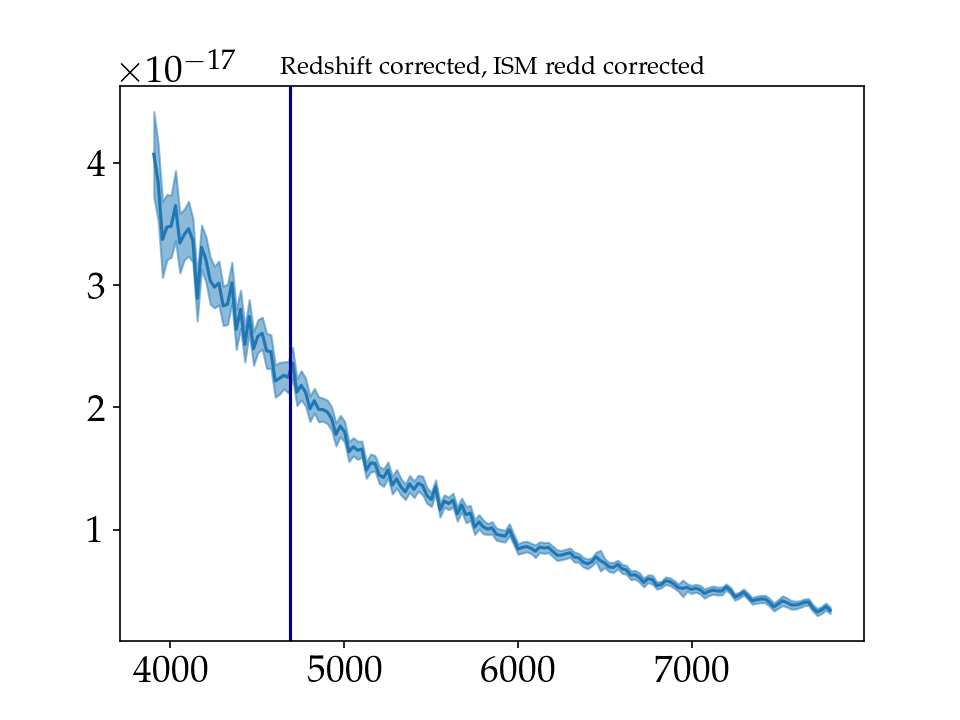

Text(4536, 2, 'HeII')

In [44]:
plt.figure()
plt.title('Redshift corrected, ISM redd corrected')
h = plt.plot(ZTF18acqwdla_spec['wl'], ZTF18acqwdla_spec['flux'])
plt.fill_between(ZTF18acqwdla_spec['wl'], 
                 ZTF18acqwdla_spec['flux'] + np.sqrt(ZTF18acqwdla_spec['var']),
                 ZTF18acqwdla_spec['flux'] - np.sqrt(ZTF18acqwdla_spec['var']), 
                 alpha=0.5, color=h[0].get_color())
# plt.axvline(4861, color = 'red' ) 
# plt.text(4861+10, 1.7, r'H $\beta$', color = 'red')
plt.axvline(4686, color = 'darkblue') 
plt.text(4686-150, 2, 'HeII', color = 'darkblue', rotation = 90)

# ZTF19aatqzrb

In [43]:
ZTF19aatqzrb_spec = ascii.read('/Users/r.saturn/PhD/WIP/Full_RISNeII_ZTF1/2dSS_SEDm_analysis/ZTF19aatqzrb/spec_auto_byecont_lstep1__crr_b_ifu20190504_08_53_22_ZTF19aatqzrb.txt',
                              names = ['wl','flux','var'])

In [44]:
ZTF19aatqzrb_spec = correct_spectrum('ZTF19aatqzrb',ZTF19aatqzrb_spec)



In [45]:
zrbsnr = estimate_snr_over_band(ZTF19aatqzrb_spec, bandpass=[5900,6300], is_var = True)
zrbsnr





/Users/r.saturn/opt/anaconda3/envs/astropy37/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in true_divide


3.146230618393122

In [46]:
snr_noflash.append(zrbsnr)

In [46]:
test_snr = ZTF19aatqzrb_spec[(ZTF19aatqzrb_spec['wl']>=4100)&(ZTF19aatqzrb_spec['wl']<=5500)]

np.nanmedian(test_snr['flux']/np.sqrt(test_snr['var']))

2.204701418160169

In [47]:
ZTF19aatqzrb_spec = correct_spectrum('ZTF19aatqzrb',ZTF19aatqzrb_spec)

<IPython.core.display.Javascript object>


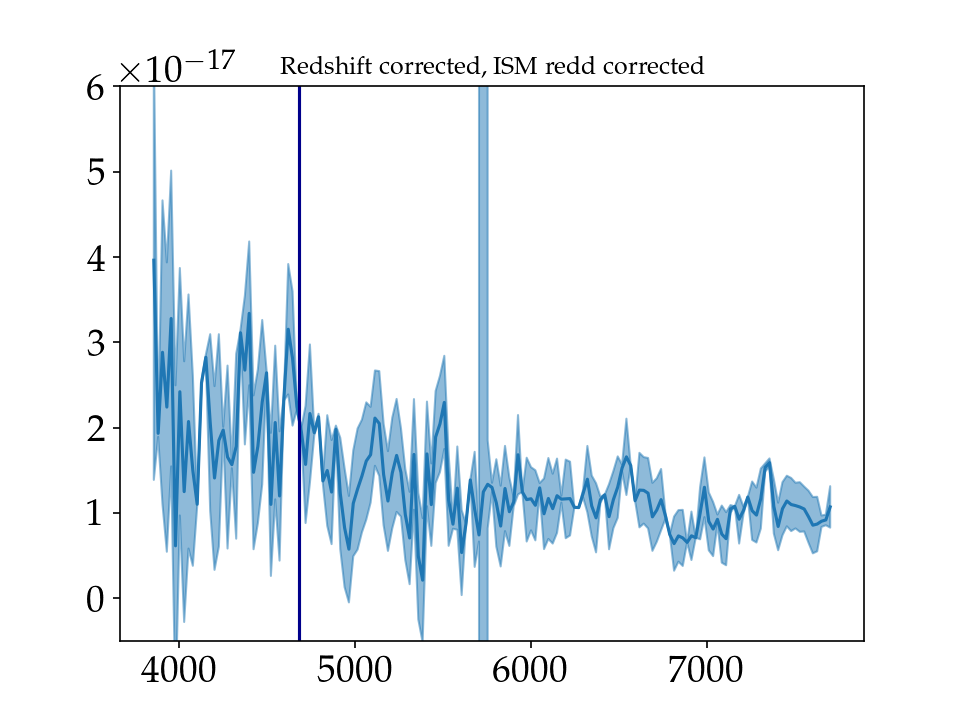

(-5e-18, 6e-17)

In [48]:
plt.figure()
plt.title('Redshift corrected, ISM redd corrected')
h = plt.plot(ZTF19aatqzrb_spec['wl'], ZTF19aatqzrb_spec['flux'])
plt.fill_between(ZTF19aatqzrb_spec['wl'], 
                 ZTF19aatqzrb_spec['flux'] + np.sqrt(ZTF19aatqzrb_spec['var']),
                 ZTF19aatqzrb_spec['flux'] - np.sqrt(ZTF19aatqzrb_spec['var']), 
                 alpha=0.5, color=h[0].get_color())
# plt.axvline(4861, color = 'red' ) 
# plt.text(4861+10, 1.7, r'H $\beta$', color = 'red')
plt.axvline(4686, color = 'darkblue') 
plt.text(4686-150, 2, 'HeII', color = 'darkblue', rotation = 90)

plt.ylim([-0.5e-17,6e-17])

# ZTF19abbwfgp

In [47]:
spec = ascii.read('/Users/r.saturn/PhD/WIP/Full_RISNeII_ZTF1/2dSS_SEDm_analysis/ZTF19abbwfgp/spec_auto_byecont_lstep1__crr_b_ifu20190629_06_12_31_ZTF19abbwfgp.txt',
                              names = ['wl','flux','var'])



In [48]:
spec = correct_spectrum('ZTF19abbwfgp',spec)

In [49]:
zrbsnr = estimate_snr_over_band(spec, bandpass=[5900,6300], is_var = True)
zrbsnr





5.065131195413894

In [50]:
zrbsnr

5.065131195413894

In [51]:
snr_noflash.append(zrbsnr)

In [127]:
test_snr = spec[(spec['wl']>=4100)&(spec['wl']<=5500)]

np.nanmedian(test_snr['flux']/np.sqrt(test_snr['var']))



19.616394807623927

<IPython.core.display.Javascript object>


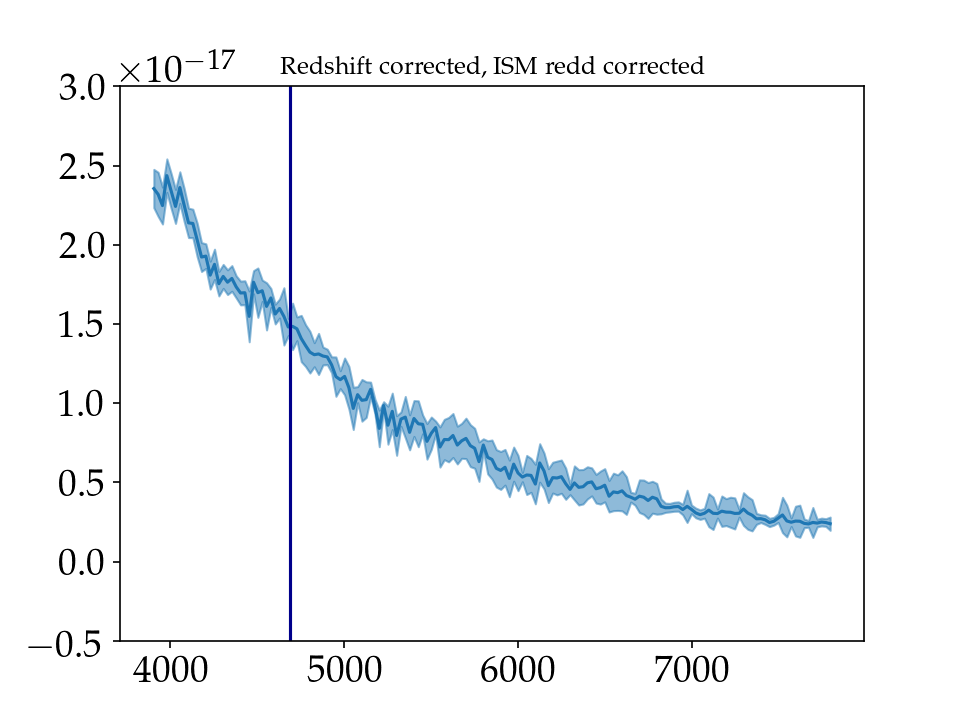

(-5e-18, 3e-17)

In [132]:



plt.figure()
plt.title('Redshift corrected, ISM redd corrected')
h = plt.plot(spec['wl'], spec['flux'])
plt.fill_between(spec['wl'], 
                 spec['flux'] + np.sqrt(spec['var']),
                 spec['flux'] - np.sqrt(spec['var']), 
                 alpha=0.5, color=h[0].get_color())
# plt.axvline(4861, color = 'red' ) 
# plt.text(4861+10, 1.7, r'H $\beta$', color = 'red')
plt.axvline(4686, color = 'darkblue') 
plt.text(4686-150, 2, 'HeII', color = 'darkblue', rotation = 90)

plt.ylim([-0.5e-17,3e-17])

# ZTF19abrlvij

The SNR is low (4) hence inconclusive for flashers. Should be removed :( 

In [52]:
ZTF19abrlvij_spec = ascii.read('/Users/r.saturn/PhD/WIP/Full_RISNeII_ZTF1/2dSS_SEDm_analysis/ZTF19abrlvij/spec_auto_byecont_lstep1__crr_b_ifu20190824_08_42_55_ZTF19abrlvij.txt',
                              names = ['wl','flux','var'])

In [53]:
ZTF19abrlvij_spec = correct_spectrum('ZTF19abrlvij',ZTF19abrlvij_spec)

vijsnr = estimate_snr_over_band(ZTF19abrlvij_spec, bandpass=[5900,6300], is_var = True)
vijsnr




5.429206536451919

In [54]:
snr_noflash.append(vijsnr)

In [53]:
test_snr_vij = ZTF19abrlvij_spec[(ZTF19abrlvij_spec['wl']>=4100)&(ZTF19abrlvij_spec['wl']<=5500)]

np.nanmedian(test_snr_vij['flux']/np.sqrt(test_snr_vij['var']))

4.05149052560247

In [54]:
ZTF19abrlvij_spec = correct_spectrum('ZTF19abrlvij',ZTF19abrlvij_spec)

<IPython.core.display.Javascript object>


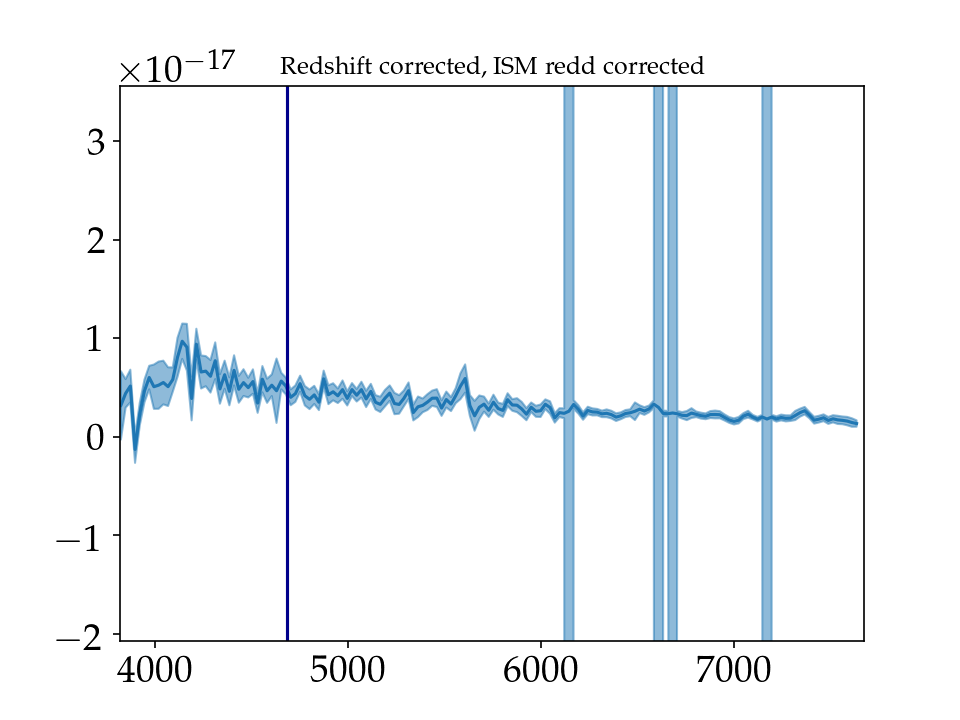

Text(4536, 2, 'HeII')

In [55]:

plt.figure()
plt.title('Redshift corrected, ISM redd corrected')
h = plt.plot(ZTF19abrlvij_spec['wl'], ZTF19abrlvij_spec['flux'])
plt.fill_between(ZTF19abrlvij_spec['wl'], 
                 ZTF19abrlvij_spec['flux'] + np.sqrt(ZTF19abrlvij_spec['var']),
                 ZTF19abrlvij_spec['flux'] - np.sqrt(ZTF19abrlvij_spec['var']), 
                 alpha=0.5, color=h[0].get_color())
# plt.axvline(4861, color = 'red' ) 
# plt.text(4861+10, 1.7, r'H $\beta$', color = 'red')
plt.axvline(4686, color = 'darkblue') 
plt.text(4686-150, 2, 'HeII', color = 'darkblue', rotation = 90)

# ZTF20aasfhia

In [55]:
spec = ascii.read('/Users/r.saturn/PhD/WIP/Full_RISNeII_ZTF1/2dSS_SEDm_analysis/ZTF20aasfhia/spec_auto_byecont_lstep1__crr_b_ifu20200305_07_37_25_ZTF20aasfhia.txt',
                              names = ['wl','flux','var'])



test_snr = spec[(spec['wl']>=4100)&(spec['wl']<=5500)]

np.nanmedian(test_snr['flux']/np.sqrt(test_snr['var']))



12.710671650817607

In [56]:
spec = correct_spectrum('ZTF20aasfhia',spec)

hiasnr = estimate_snr_over_band(spec, bandpass=[5900,6300], is_var = True)
hiasnr






12.558027321771457

In [57]:
snr_noflash.append(hiasnr)

In [57]:
spec = correct_spectrum('ZTF20aasfhia',spec)

<IPython.core.display.Javascript object>


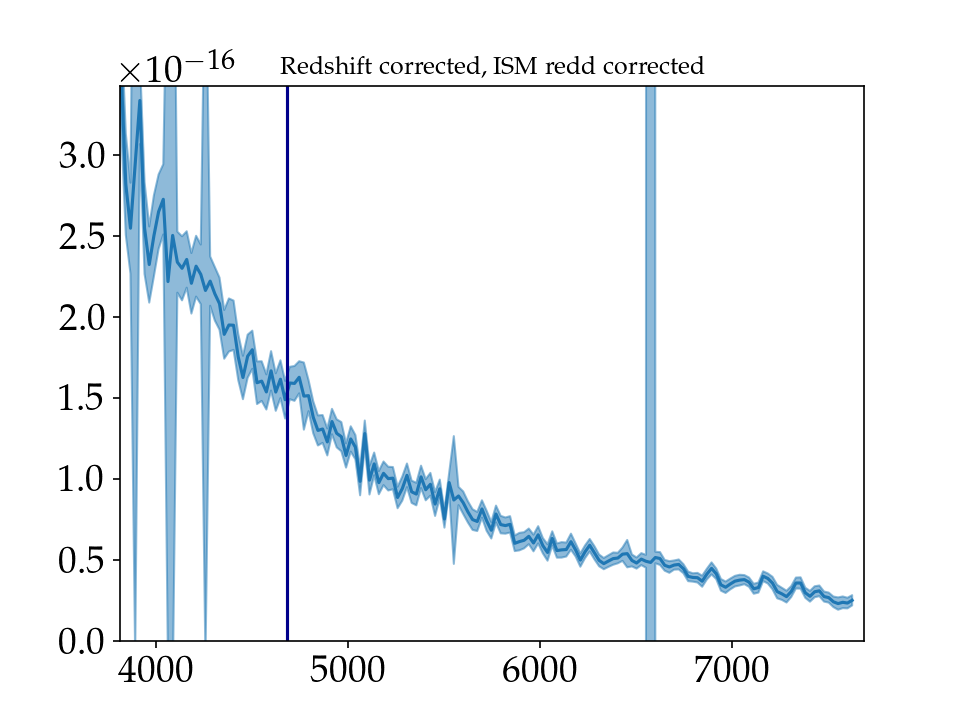

Text(4536, 2, 'HeII')

In [59]:



plt.figure()
plt.title('Redshift corrected, ISM redd corrected')
h = plt.plot(spec['wl'], spec['flux'])
plt.fill_between(spec['wl'], 
                 spec['flux'] + np.sqrt(spec['var']),
                 spec['flux'] - np.sqrt(spec['var']), 
                 alpha=0.5, color=h[0].get_color())
# plt.axvline(4861, color = 'red' ) 
# plt.text(4861+10, 1.7, r'H $\beta$', color = 'red')
plt.axvline(4686, color = 'darkblue') 
plt.text(4686-150, 2, 'HeII', color = 'darkblue', rotation = 90)

# plt.ylim([-0.5e-17,3e-17])

# ZTF20aasijew

In [58]:
spec = ascii.read('/Volumes/Machiavelli/WIP/Full_Infant_SNeII/data/2020/ZTF20aasijew/spectroscopy/ZTF20aasijew_20200305_P60_v1.ascii',
                              names = ['wl','flux','var'])



test_snr = spec[(spec['wl']>=4100)&(spec['wl']<=5500)]

np.nanmedian(test_snr['flux']/np.sqrt(test_snr['var']))




16.079983666969987

In [59]:
spec = correct_spectrum('ZTF20aasijew',spec)

jewsnr = estimate_snr_over_band(spec, bandpass=[4000,5000], is_var = True)
jewsnr








15.469742679551299

In [60]:
snr_noflash.append(jewsnr)

In [61]:
spec = correct_spectrum('ZTF20aasijew',spec)

<IPython.core.display.Javascript object>


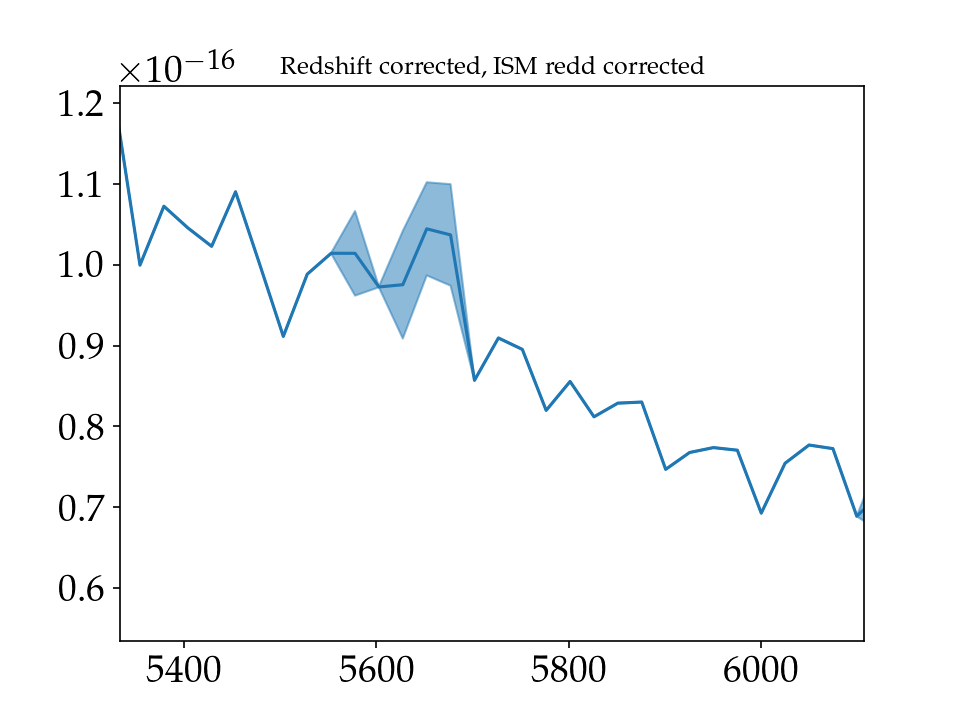

Text(4536, 2, 'HeII')

In [149]:


plt.figure()
plt.title('Redshift corrected, ISM redd corrected')
h = plt.plot(spec['wl'], spec['flux'])
plt.fill_between(spec['wl'], 
                 spec['flux'] + np.sqrt(spec['var']),
                 spec['flux'] - np.sqrt(spec['var']), 
                 alpha=0.5, color=h[0].get_color())
# plt.axvline(4861, color = 'red' ) 
# plt.text(4861+10, 1.7, r'H $\beta$', color = 'red')
plt.axvline(4686, color = 'darkblue') 
plt.text(4686-150, 2, 'HeII', color = 'darkblue', rotation = 90)

# plt.ylim([-0.5e-17,3e-17])

## ZTF20abybeex

In [61]:
spec = ascii.read('/Users/r.saturn/PhD/WIP/Full_RISNeII_ZTF1/2dSS_SEDm_analysis/ZTF20abybeex/spec_auto_byecont_lstep1__crr_b_ifu20200903_04_58_12_ZTF20abybeex.txt',
                              names = ['wl','flux','var'])



test_snr = spec[(spec['wl']>=4100)&(spec['wl']<=5500)]

np.nanmedian(test_snr['flux']/np.sqrt(test_snr['var']))




4.567268549249831

In [62]:
spec = correct_spectrum('ZTF20abybeex',spec)

eexsnr = estimate_snr_over_band(spec, bandpass=[4000,5000], is_var = True)
eexsnr










5.007496092599176

In [63]:
snr_noflash.append(eexsnr)

In [64]:
# spec = correct_spectrum('ZTF20abybeex',spec)

<IPython.core.display.Javascript object>


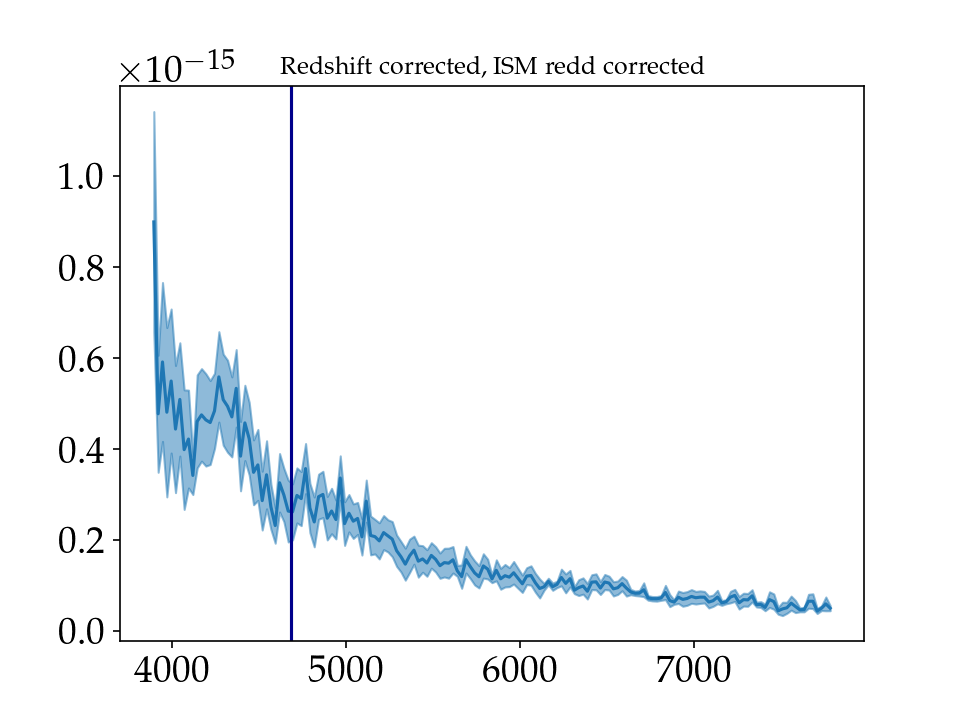

Text(4536, 2, 'HeII')

In [65]:



plt.figure()
plt.title('Redshift corrected, ISM redd corrected')
h = plt.plot(spec['wl'], spec['flux'])
plt.fill_between(spec['wl'], 
                 spec['flux'] + np.sqrt(spec['var']),
                 spec['flux'] - np.sqrt(spec['var']), 
                 alpha=0.5, color=h[0].get_color())
# plt.axvline(4861, color = 'red' ) 
# plt.text(4861+10, 1.7, r'H $\beta$', color = 'red')
plt.axvline(4686, color = 'darkblue') 
plt.text(4686-150, 2, 'HeII', color = 'darkblue', rotation = 90)

# plt.ylim([-0.5e-17,3e-17])

# ZTF20acknpig

In [64]:
spec = ascii.read('/Users/r.saturn/PhD/WIP/Full_RISNeII_ZTF1/2dSS_SEDm_analysis/ZTF20acknpig/spec_auto_byecont_lstep1__crr_b_ifu20201018_11_04_17_ZTF20acknpig.txt',
                              names = ['wl','flux','var'])



test_snr = spec[(spec['wl']>=4100)&(spec['wl']<=5500)]

np.nanmedian(test_snr['flux']/np.sqrt(test_snr['var']))




7.099298242149778

In [65]:
spec = correct_spectrum('ZTF20acknpig',spec)

pigsnr = estimate_snr_over_band(spec, bandpass=[5900,6000], is_var = True)
pigsnr












5.394896923608213

In [66]:
snr_noflash.append(pigsnr)

In [67]:
spec = correct_spectrum('ZTF20acknpig',spec)

<IPython.core.display.Javascript object>


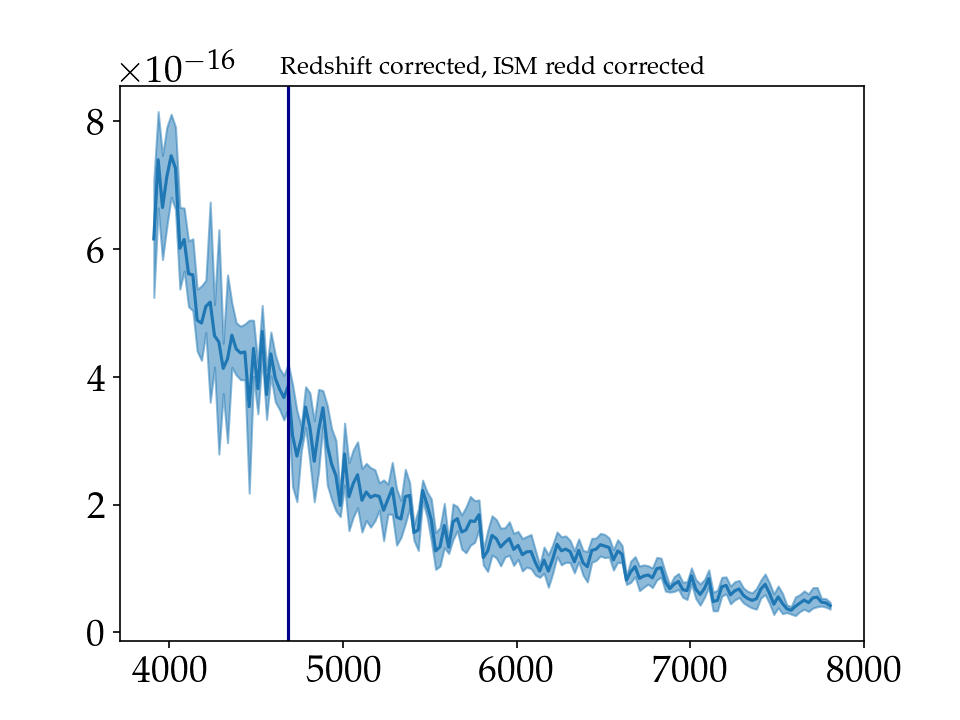

Text(4536, 2, 'HeII')

In [156]:



plt.figure()
plt.title('Redshift corrected, ISM redd corrected')
h = plt.plot(spec['wl'], spec['flux'])
plt.fill_between(spec['wl'], 
                 spec['flux'] + np.sqrt(spec['var']),
                 spec['flux'] - np.sqrt(spec['var']), 
                 alpha=0.5, color=h[0].get_color())
# plt.axvline(4861, color = 'red' ) 
# plt.text(4861+10, 1.7, r'H $\beta$', color = 'red')
plt.axvline(4686, color = 'darkblue') 
plt.text(4686-150, 2, 'HeII', color = 'darkblue', rotation = 90)

# plt.ylim([-0.5e-17,3e-17])

# ZTF20acuaqlf

In [67]:
spec = ascii.read('/Users/r.saturn/PhD/WIP/Full_RISNeII_ZTF1/2dSS_SEDm_analysis/ZTF20acuaqlf/spec_auto_byecont_lstep1__crr_b_ifu20201129_01_55_34_ZTF20acuaqlf.txt',
                              names = ['wl','flux','var'])



test_snr = spec[(spec['wl']>=4100)&(spec['wl']<=5500)]

np.nanmedian(test_snr['flux']/np.sqrt(test_snr['var']))




7.555786481309874

In [68]:
spec = correct_spectrum('ZTF20acuaqlf',spec)

In [69]:


qlfsnr = estimate_snr_over_band(spec, bandpass=[5900,6300], is_var = True)
qlfsnr















15.519392740756274

In [70]:
snr_noflash.append(qlfsnr)

In [70]:
spec = correct_spectrum('ZTF20acuaqlf',spec)

<IPython.core.display.Javascript object>


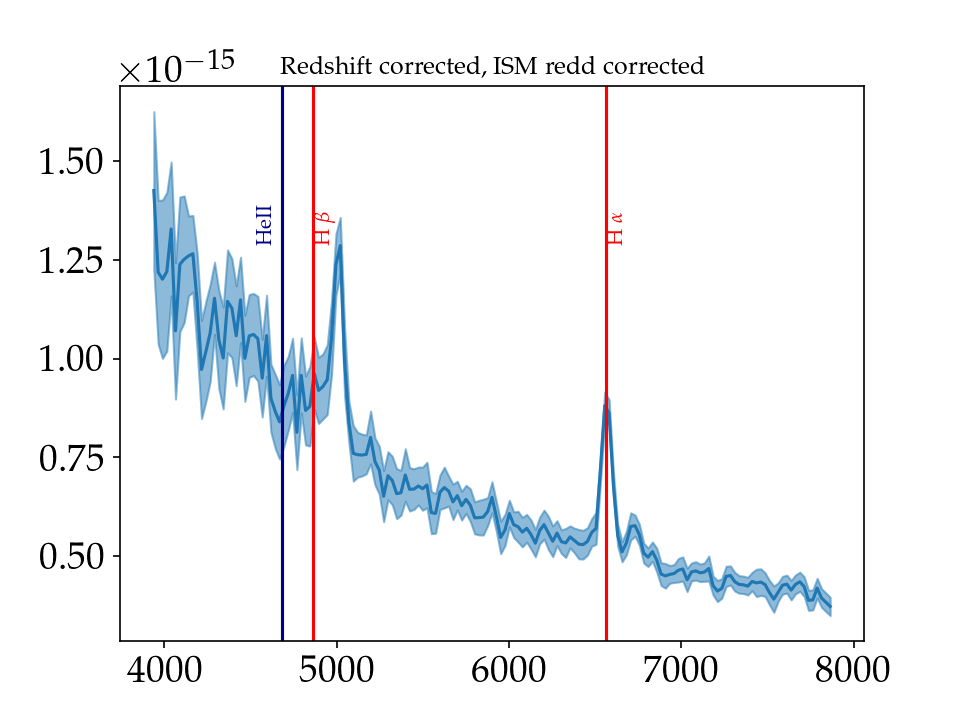

Text(4536, 1.3e-15, 'HeII')

In [159]:


plt.figure()
plt.title('Redshift corrected, ISM redd corrected')
h = plt.plot(spec['wl'], spec['flux'])
plt.fill_between(spec['wl'], 
                 spec['flux'] + np.sqrt(spec['var']),
                 spec['flux'] - np.sqrt(spec['var']), 
                 alpha=0.5, color=h[0].get_color())
plt.axvline(4861, color = 'red' ) 
plt.text(4861+10, 1.3e-15, r'H $\beta$', color = 'red',rotation = 90)
plt.axvline(6563, color = 'red' ) 
plt.text(6563+10, 1.3e-15, r'H $\alpha$', color = 'red',rotation = 90)

plt.axvline(4686, color = 'darkblue') 
plt.text(4686-150, 1.3e-15, 'HeII', color = 'darkblue', rotation = 90)

# plt.ylim([-0.5e-17,3e-17])

# ZTF20acwgxhk

In [71]:
spec = ascii.read('/Users/r.saturn/PhD/WIP/Full_RISNeII_ZTF1/2dSS_SEDm_analysis/ZTF20acwgxhk/spec_auto_byecont_lstep1__crr_b_ifu20201210_05_29_02_ZTF20acwgxhk.txt',
                              names = ['wl','flux','var'])



test_snr = spec[(spec['wl']>=4100)&(spec['wl']<=5500)]

np.nanmedian(test_snr['flux']/np.sqrt(test_snr['var']))




15.883599629849817

In [72]:
spec = correct_spectrum('ZTF20acwgxhk',spec)

In [73]:


xhksnr = estimate_snr_over_band(spec, bandpass=[5900,6300], is_var = True)
xhksnr



11.904047025550112

In [74]:
snr_noflash.append(xhksnr)

<IPython.core.display.Javascript object>


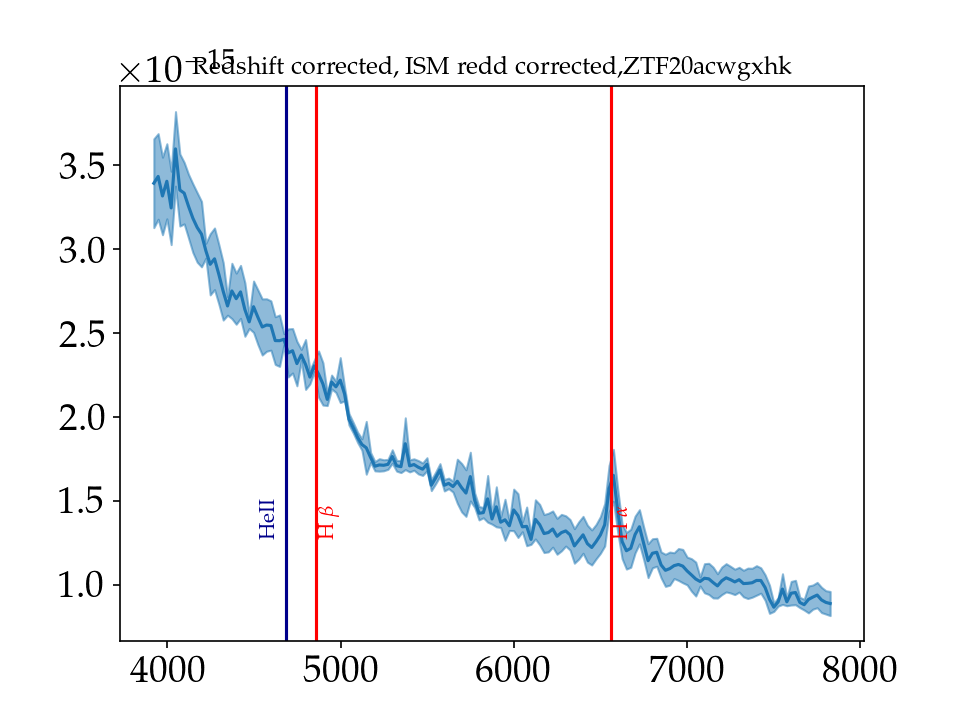

Text(4536, 1.3e-15, 'HeII')

In [169]:
plt.figure()
plt.title('Redshift corrected, ISM redd corrected,ZTF20acwgxhk ')
h = plt.plot(spec['wl'], spec['flux'])
plt.fill_between(spec['wl'], 
                 spec['flux'] + np.sqrt(spec['var']),
                 spec['flux'] - np.sqrt(spec['var']), 
                 alpha=0.5, color=h[0].get_color())
plt.axvline(4861, color = 'red' ) 
plt.text(4861+10, 1.3e-15, r'H $\beta$', color = 'red',rotation = 90)
plt.axvline(6563, color = 'red' ) 
plt.text(6563+10, 1.3e-15, r'H $\alpha$', color = 'red',rotation = 90)

plt.axvline(4686, color = 'darkblue') 
plt.text(4686-150, 1.3e-15, 'HeII', color = 'darkblue', rotation = 90)

# plt.ylim([-0.5e-17,3e-17])

In [75]:
sedm_fs_noflash['FS_SEDm_SNR'] = snr_noflash

In [170]:
# withSNR = ascii.read('/Users/r.saturn/PhD/WIP/Full_RISNeII_ZTF1/tables/2dsubsample_SEDm_noflash_gband.csv', delimiter = ',')

In [172]:
# withSNR['name','SNr_FS']

In [76]:
standardo = vstack([sedm_fs_flash,sedm_fs_noflash])

In [77]:
standardo

name,rach-classification,Flasher,classification,First Detection,Last Non Detection,First Spectrum,instrument-fs,fD-lND,fS-lND,ra_med,dec_med,redshift,e_redshift,z_ref,jd-redshift,instrument-redshift,UV,host,host_type,P-cygni,jd-pcyg,instrument-pcyg,t_exp,e_t_exp,jd_t_exp,Fs-Texp,peakabsmag_r,e_peakabsmag_r,peakday_r,e_peakday_r,peakabsmag_g,e_peakabsmag_g,peakday_g,e_peakday_g,decline_r,e_decline_r,decline_g,e_decline_g,climb_time_r,climb_time_g,FS_SEDm_SNR
str12,str10,str4,str6,float64,float64,float64,str11,float64,float64,float64,float64,float64,float64,str69,float64,str11,str4,str4,str12,str4,float64,str11,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
ZTF18abeajml,SN II,yes,SN II,2458303.799,2458302.797,2458304.794,SEDm+P60,1.0019,1.99674769,252.03236,24.3040949,0.036526,8.6e-05,2005SDSS4.C...0000:,--,--,yes,yes,notype,yes,2458331.71,SEDm+P60,-0.02632267313,1.331885814,2458303.773,1.02132267,-18.50264443512861,0.015414958320710454,10.42687184147541,1.5013246095658397,-18.549787640366937,0.007498228090990184,7.372101208620604,1.351557480278869,0.0204867406038592,0.0009898916851182882,0.03619533929041421,0.0026608903799914055,6.572604715042432,4.575926693168947,24.094204926138396
ZTF18abwlsoi,SN II,yes,SN II,2458377.63,2458376.74,2458377.751,SEDm+P60,0.8952,1.0131723,261.897614,71.530251,0.05376479944,0.007318710553,meas,2458443.6,SEDm+P60,no,yes,--,yes,2458443.6,SEDm+P60,-0.02146235453,0.002665623404,2458377.609,0.14246235,-18.518220748706636,0.29569547023108217,6.291511375496778,0.3851094457398963,-18.581476347170103,0.2963036637351274,4.884686383300792,0.285709373570058,0.031614797151004376,0.008121157616170814,0.045954074587724325,0.007425436176296284,4.868515110202693,3.165895028481702,23.53293286516789
ZTF19abqhobb,SN II,yes,SN II,2458714.663,2458713.742,2458714.792,SEDm+P60,0.9213,1.0508631,261.4111,59.4467303,0.01815,1e-05,2006AJ....132..231P,--,--,yes,yes,Scd( f ),yes,2458878.71,ALFOSC+NOT,-0.0379833268,0.00608132416,2458714.625,0.16698333,-17.64125267005545,0.00866796071694527,8.582697522693397,0.5669372272342655,-17.465368004847953,0.019635823367565336,7.682337884769271,1.2202711183018025,0.010103578145785736,0.0007073497740846882,0.02204664496274497,0.0014619438297216788,7.833160915760206,4.327674459143019,22.83038984282009
ZTF18acqwdla,SN II,no,SN II,2458443.874,2458443.789,2458443.937,SEDm+P60,0.0855324,0.1481347,106.472662,12.8929375,0.026212141,0.004739291488,meas,2458616.456,EFOSC2+NTT,no,yes,--,yes,2458616.456,EFOSC2+NTT,-0.04249999998,0.04249999998,2458443.832,0.1055,-18.60137684700958,0.39262836644613214,12.183829851753528,1.2991954919750475,-18.754296156407,0.39288470141123233,11.513745758265994,0.38590822695090043,0.01596825397963348,0.0006413914572852468,0.03923859349765954,0.0008299446480697324,99.0,99.0,20.03681375238602
ZTF19aatqzrb,SN II,no,SN II,2458606.799,2458605.888,2458607.87,SEDm+P60,0.9103588,1.9821106,221.652383,56.2342197,0.038136,9e-05,1988AJ.....95.1602S,--,--,no,yes,notype,no?,2458616.902,DBSP+P200,-0.01225465929,0.002565603556,2458606.787,1.08325466,-17.203746852930166,0.013660957745520251,17.561061757168286,0.729005380149389,-16.97636231923359,0.01592565259282788,10.330295126430208,0.9424960372674184,0.010127175501533262,0.0026255683466046543,0.02635034078202941,0.003927785695777718,13.29031357816509,5.845258530462861,3.146230618393122
ZTF19abbwfgp,SN II,no,SN IIP,2458661.82,2458660.843,2458663.759,SEDm+P60,0.9774,2.9160862,258.323795,43.7843194,0.025925,0.000117,1996AJ....112.1803M,--,--,no,yes,notype,yes,2458765.626,SEDm+P60,-0.003414843865,3.554028127,2458661.817,1.94241484,-18.186342251238855,0.014048037207915394,16.568761702761094,3.902908966038234,-18.320690934249058,0.012077415898528105,10.069203091028774,3.5684189048473307,0.010489959256260756,0.0008571756329513857,0.026363764932218915,0.0018966819703930445,8.963188294655511,6.870977314482737,5.065131195413894
ZTF19abrlvij,

## The SNR for the non flashers was below 20 and often below 10. Hence disqualifying them from being flashers is not believable ...\


In [64]:
sedm_fs_flash

name,rach-classification,Flasher,classification,First Detection,Last Non Detection,First Spectrum,instrument-fs,fD-lND,fS-lND,ra_med,dec_med,redshift,e_redshift,z_ref,jd-redshift,instrument-redshift,UV,host,host_type,P-cygni,jd-pcyg,instrument-pcyg,t_exp,e_t_exp,jd_t_exp,Fs-Texp,peakabsmag_r,e_peakabsmag_r,peakday_r,e_peakday_r,peakabsmag_g,e_peakabsmag_g,peakday_g,e_peakday_g,decline_r,e_decline_r,decline_g,e_decline_g,climb_time_r,climb_time_g,FS_SEDm_SNR
str12,str10,str4,str6,float64,float64,float64,str11,float64,float64,float64,float64,float64,float64,str69,float64,str11,str4,str4,str12,str4,float64,str11,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
ZTF18abeajml,SN II,yes,SN II,2458303.799,2458302.797,2458304.794,SEDm+P60,1.0019,1.99674769,252.03236,24.3040949,0.036526,8.6e-05,2005SDSS4.C...0000:,--,--,yes,yes,notype,yes,2458331.71,SEDm+P60,-0.02632267313,1.331885814,2458303.773,1.02132267,-18.50264443512861,0.015414958320710454,10.42687184147541,1.5013246095658397,-18.549787640366937,0.007498228090990184,7.372101208620604,1.351557480278869,0.0204867406038592,0.0009898916851182882,0.03619533929041421,0.0026608903799914055,6.572604715042432,4.575926693168947,29.78621330744487
ZTF18abwlsoi,SN II,yes,SN II,2458377.63,2458376.74,2458377.751,SEDm+P60,0.8952,1.0131723,261.897614,71.530251,0.05376479944,0.007318710553,meas,2458443.6,SEDm+P60,no,yes,--,yes,2458443.6,SEDm+P60,-0.02146235453,0.002665623404,2458377.609,0.14246235,-18.518220748706636,0.29569547023108217,6.291511375496778,0.3851094457398963,-18.581476347170103,0.2963036637351274,4.884686383300792,0.285709373570058,0.031614797151004376,0.008121157616170814,0.045954074587724325,0.007425436176296284,4.868515110202693,3.165895028481702,21.88138519571333
ZTF19abqhobb,SN II,yes,SN II,2458714.663,2458713.742,2458714.792,SEDm+P60,0.9213,1.0508631,261.4111,59.4467303,0.01815,1e-05,2006AJ....132..231P,--,--,yes,yes,Scd( f ),yes,2458878.71,ALFOSC+NOT,-0.0379833268,0.00608132416,2458714.625,0.16698333,-17.64125267005545,0.00866796071694527,8.582697522693397,0.5669372272342655,-17.465368004847953,0.019635823367565336,7.682337884769271,1.2202711183018025,0.010103578145785736,0.0007073497740846882,0.02204664496274497,0.0014619438297216788,7.833160915760206,4.327674459143019,18.211276971453373


In [84]:
# sedm_fs_noflash['FS_SEDm_SNR'] = withSNR['SNr_FS']

In [78]:
sedm_fs_standardsnii = vstack([sedm_fs_flash,sedm_fs_noflash])

In [79]:
sedm_fs_standardsnii['name','Flasher','FS_SEDm_SNR']

name,Flasher,FS_SEDm_SNR
str12,str4,float64
ZTF18abeajml,yes,24.094204926138396
ZTF18abwlsoi,yes,23.53293286516789
ZTF19abqhobb,yes,22.83038984282009
ZTF18acqwdla,no,20.03681375238602
ZTF19aatqzrb,no,3.146230618393122
ZTF19abbwfgp,no,5.065131195413894
ZTF19abrlvij,no,5.429206536451919
ZTF20aasfhia,no,12.558027321771457
ZTF20aasijew,no,15.469742679551299


In [80]:
LC               = '/Users/r.saturn/PhD/WIP/Full_RISNeII_ZTF1/forced_photometry/case_by_case/fp_lc_extzcorr/'
SAVE_INTERP      = '/Users/r.saturn/PhD/WIP/Full_RISNeII_ZTF1/full_lc_interpolation/'

mag_atFS   = []
e_mag_atFS = []


valmag_atFS   = []
e_valmag_atFS = []

for _ in range(len(sedm_fs_standardsnii)):
    
    candiname = sedm_fs_standardsnii['name'][_]
    t_fs      = sedm_fs_standardsnii['Fs-Texp'][_]
    
    try: 
        _tabinter = ascii.read(SAVE_INTERP+f'/tables/{candiname}_gband_interpolation.csv', delimiter = ',')
        low       = math.floor(t_fs) 
        up        = math.floor(t_fs) + 1
        
        tab_at_fs   = _tabinter[ (_tabinter['t_g']>= low) & (_tabinter['t_g']<= up) ]
        tab_at_fs   = tab_at_fs[np.isnan(tab_at_fs['mag'])== False]
        
        mag_at_fs   = np.median(tab_at_fs['mag'])
        e_mag_at_fs = np.std(tab_at_fs['mag'])
        
        mag_atFS.append(mag_at_fs)
        e_mag_atFS.append(e_mag_at_fs)
        
        
        
    except FileNotFoundError:
        print(f'No interpo for {candiname}')
        mag_atFS.append(99.)
        e_mag_atFS.append(99.)
        
    try:
        _tablc    = ascii.read(LC+f'{candiname}_gband_exzcorr.ascii')
        
        low       = math.floor(t_fs) 
        up        = math.floor(t_fs) + 1
        
        vtab_at_fs   = _tablc[ (_tablc['tfromexplo_zc']>= low) & (_tablc['tfromexplo_zc']<= up) ]

        
        if len(vtab_at_fs)>0:
            vmag_at_fs   = np.median(vtab_at_fs['mag'])
            e_vmag_at_fs = np.median(vtab_at_fs['emag'])
            
            valmag_atFS.append(vmag_at_fs)
            e_valmag_atFS.append(e_vmag_at_fs)
            
        else:
            valmag_atFS.append(99.)
            e_valmag_atFS.append(99.)

    except FileNotFoundError:
        print(f'No data for {candiname}')
        valmag_atFS.append(99.)
        e_valmag_atFS.append(99.)
        




No interpo for ZTF18acqwdla
No interpo for ZTF20aasijew


In [81]:
sedm_fs_standardsnii['mag_at_FS_interp']  = mag_atFS
sedm_fs_standardsnii['emag_at_FS_interp'] = e_mag_atFS

sedm_fs_standardsnii['mag_at_FS_meas']    = valmag_atFS
sedm_fs_standardsnii['emag_at_FS_meas']   = e_valmag_atFS

matfs  = []
ematfs = []

for _ in range(len(sedm_fs_standardsnii)):
    meas = sedm_fs_standardsnii['mag_at_FS_meas'][_]
    inte = sedm_fs_standardsnii['mag_at_FS_interp'][_]
    
    emeas = sedm_fs_standardsnii['emag_at_FS_meas'][_]
    einte = sedm_fs_standardsnii['emag_at_FS_interp'][_]
    
    
    if meas == 99.:
        matfs.append(inte)
    elif inte == 99.:
        matfs.append(meas)
    elif np.isnan(inte)==True:
        matfs.append(meas)
    else:
        matfs.append(np.mean([inte,meas]))
        
    if (emeas == 0.) | (emeas == 99.):
        ematfs.append(einte)
        
    elif (einte == 0.) | (einte == 99.) | (np.isnan(einte)==True):
        ematfs.append(emeas)
    
    else:
        ematfs.append(np.mean([einte,emeas]))
        

In [82]:

        
    

sedm_fs_standardsnii['magcorr_at_FS']  = matfs
sedm_fs_standardsnii['emagcorr_at_FS'] = ematfs

In [83]:
_p48   = { 'ZTF_r': 6339.6,'ZTF_g': 4722.7,'ZTF_i': 7886.1 }
# the EBV depends on the position
gal_reddening            = sfdmap.SFDMap('/Volumes/Machiavelli/code_library/python/sfddata-master/', scaling=0.86)


ebv_g = []
for candi in sedm_fs_standardsnii['name']:
    _temp = sedm_fs_standardsnii[sedm_fs_standardsnii['name']==candi]
    co    = SkyCoord (np.array(_temp['ra_med'][0]),np.array(_temp['dec_med'][0]),unit = 'deg', frame = 'fk5')
    ebv   = gal_reddening.ebv(co)
    ebv_g.append(ebv)
    
sedm_fs_standardsnii['EBV'] = ebv_g


In [84]:
extinction_g = []

for i in range(len(sedm_fs_standardsnii['EBV'])):
    ebv_ = sedm_fs_standardsnii['EBV'][i]
    alamg = extinction.ccm89(np.array([_p48.get('ZTF_g')]) , ebv_ * 3.1, 3.1, unit = 'aa')
    extinction_g.append(alamg[0])
    
sedm_fs_standardsnii['extinction'] = extinction_g

In [85]:
sedm_fs_standardsnii['app_mag_g_at_FS']  = sedm_fs_standardsnii['magcorr_at_FS'] + sedm_fs_standardsnii['extinction']

In [86]:
sedm_fs_standardsnii.colnames


['name',
 'rach-classification',
 'Flasher',
 'classification',
 'First Detection',
 'Last Non Detection',
 'First Spectrum',
 'instrument-fs',
 'fD-lND',
 'fS-lND',
 'ra_med',
 'dec_med',
 'redshift',
 'e_redshift',
 'z_ref',
 'jd-redshift',
 'instrument-redshift',
 'UV',
 'host',
 'host_type',
 'P-cygni',
 'jd-pcyg',
 'instrument-pcyg',
 't_exp',
 'e_t_exp',
 'jd_t_exp',
 'Fs-Texp',
 'peakabsmag_r',
 'e_peakabsmag_r',
 'peakday_r',
 'e_peakday_r',
 'peakabsmag_g',
 'e_peakabsmag_g',
 'peakday_g',
 'e_peakday_g',
 'decline_r',
 'e_decline_r',
 'decline_g',
 'e_decline_g',
 'climb_time_r',
 'climb_time_g',
 'FS_SEDm_SNR',
 'mag_at_FS_interp',
 'emag_at_FS_interp',
 'mag_at_FS_meas',
 'emag_at_FS_meas',
 'magcorr_at_FS',
 'emagcorr_at_FS',
 'EBV',
 'extinction',
 'app_mag_g_at_FS']

In [87]:
sedm_fs_ssnii = sedm_fs_standardsnii['name',
 'rach-classification',
 'Flasher',
 'First Detection',
 'Last Non Detection',
 'First Spectrum',
 'app_mag_g_at_FS',
 'emagcorr_at_FS',
 'instrument-fs',
 'FS_SEDm_SNR',
 'ra_med',
 'dec_med',
 'redshift',
 'e_redshift',
 'z_ref',
 'jd-redshift',
 'instrument-redshift',
 'UV',
 'host',
 'host_type',
 'P-cygni',
 'jd-pcyg',
 'instrument-pcyg',
 't_exp',
 'e_t_exp',
 'jd_t_exp',
 'Fs-Texp',
 'peakabsmag_r',
 'e_peakabsmag_r',
 'peakday_r',
 'e_peakday_r',
 'peakabsmag_g',
 'e_peakabsmag_g',
 'peakday_g',
 'e_peakday_g',
 'decline_r',
 'e_decline_r',
 'decline_g',
 'e_decline_g',
 'climb_time_r',
 'climb_time_g', 
 'EBV',
 'extinction'
]

In [88]:
sedm_fs_ssnii

name,rach-classification,Flasher,First Detection,Last Non Detection,First Spectrum,app_mag_g_at_FS,emagcorr_at_FS,instrument-fs,FS_SEDm_SNR,ra_med,dec_med,redshift,e_redshift,z_ref,jd-redshift,instrument-redshift,UV,host,host_type,P-cygni,jd-pcyg,instrument-pcyg,t_exp,e_t_exp,jd_t_exp,Fs-Texp,peakabsmag_r,e_peakabsmag_r,peakday_r,e_peakday_r,peakabsmag_g,e_peakabsmag_g,peakday_g,e_peakday_g,decline_r,e_decline_r,decline_g,e_decline_g,climb_time_r,climb_time_g,EBV,extinction
str12,str10,str4,float64,float64,float64,float64,float64,str11,float64,float64,float64,float64,float64,str69,float64,str11,str4,str4,str12,str4,float64,str11,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
ZTF18abeajml,SN II,yes,2458303.799,2458302.797,2458304.794,18.04067638735198,0.03653236629852588,SEDm+P60,24.094204926138396,252.03236,24.3040949,0.036526,8.6e-05,2005SDSS4.C...0000:,--,--,yes,yes,notype,yes,2458331.71,SEDm+P60,-0.02632267313,1.331885814,2458303.773,1.02132267,-18.50264443512861,0.015414958320710454,10.42687184147541,1.5013246095658397,-18.549787640366937,0.007498228090990184,7.372101208620604,1.351557480278869,0.0204867406038592,0.0009898916851182882,0.03619533929041421,0.0026608903799914055,6.572604715042432,4.575926693168947,0.07315470564211224,0.27427668320750137
ZTF18abwlsoi,SN II,yes,2458377.63,2458376.74,2458377.751,18.91167917327042,0.06931693864093659,SEDm+P60,23.53293286516789,261.897614,71.530251,0.05376479944,0.007318710553,meas,2458443.6,SEDm+P60,no,yes,--,yes,2458443.6,SEDm+P60,-0.02146235453,0.002665623404,2458377.609,0.14246235,-18.518220748706636,0.29569547023108217,6.291511375496778,0.3851094457398963,-18.581476347170103,0.2963036637351274,4.884686383300792,0.285709373570058,0.031614797151004376,0.008121157616170814,0.045954074587724325,0.007425436176296284,4.868515110202693,3.165895028481702,0.030648735897418435,0.11491036089423451
ZTF19abqhobb,SN II,yes,2458714.663,2458713.742,2458714.792,17.781373581944266,0.0686434604987059,SEDm+P60,22.83038984282009,261.4111,59.4467303,0.01815,1e-05,2006AJ....132..231P,--,--,yes,yes,Scd( f ),yes,2458878.71,ALFOSC+NOT,-0.0379833268,0.00608132416,2458714.625,0.16698333,-17.64125267005545,0.00866796071694527,8.582697522693397,0.5669372272342655,-17.465368004847953,0.019635823367565336,7.682337884769271,1.2202711183018025,0.010103578145785736,0.0007073497740846882,0.02204664496274497,0.0014619438297216788,7.833160915760206,4.327674459143019,0.025703243328083596,0.09636837802603117
ZTF18acqwdla,SN II,no,2458443.874,2458443.789,2458443.937,17.77042706125649,0.023086135528066695,SEDm+P60,20.03681375238602,106.472662,12.8929375,0.026212141,0.004739291488,meas,2458616.456,EFOSC2+NTT,no,yes,--,yes,2458616.456,EFOSC2+NTT,-0.04249999998,0.04249999998,2458443.832,0.1055,-18.60137684700958,0.39262836644613214,12.183829851753528,1.2991954919750475,-18.754296156407,0.39288470141123233,11.513745758265994,0.38590822695090043,0.01596825397963348,0.0006413914572852468,0.03923859349765954,0.0008299446480697324,99.0,99.0,0.05409120361763992,0.2028024826116915
ZTF19aatqzrb,SN II,no,2458606.799,2458605.888,2458607.87,19.60388763881076,0.07541646783985895,SEDm+P60,3.146230618393122,221.652383,56.2342197,0.038136,9e-05,1988AJ.....95.1602S,--,--,no,yes,notype,no?,2458616.902,DBSP+P200,-0.01225465929,0.002565603556,2458606.787,1.08325466,-17.203746852930166,0.013660957745520251,17.561061757168286,0.729005380149389,-16.97636231923359,0.01592565259282788,10.330295126430208,0.9424960372674184,0.010127175501533262,0.0026255683466046543,0.02635034078202941,0.003927785695777718,13.29031357816509,5.845258530462861,0.014280407532998413,0.053541091835758635
ZTF19abbwfgp,SN II,no,2458661.82,2458660.843,2458663.759,17.436382944072598,0.044929189901271156,SEDm+P60,5.065131195413894,258.323795,43.7843194,0.025925,0.000117,1996AJ....112.1803M,--,--,no,yes,notype,yes,2458765.626,SEDm+P60,-0.003414843865,3.554028127

In [89]:
# ascii.write(sedm_fs_ssnii,'/Users/r.saturn/PhD/WIP/Full_RISNeII_ZTF1/tables/sedm_2dsubdamp_snr_07042022.csv', delimiter = ',')

<IPython.core.display.Javascript object>


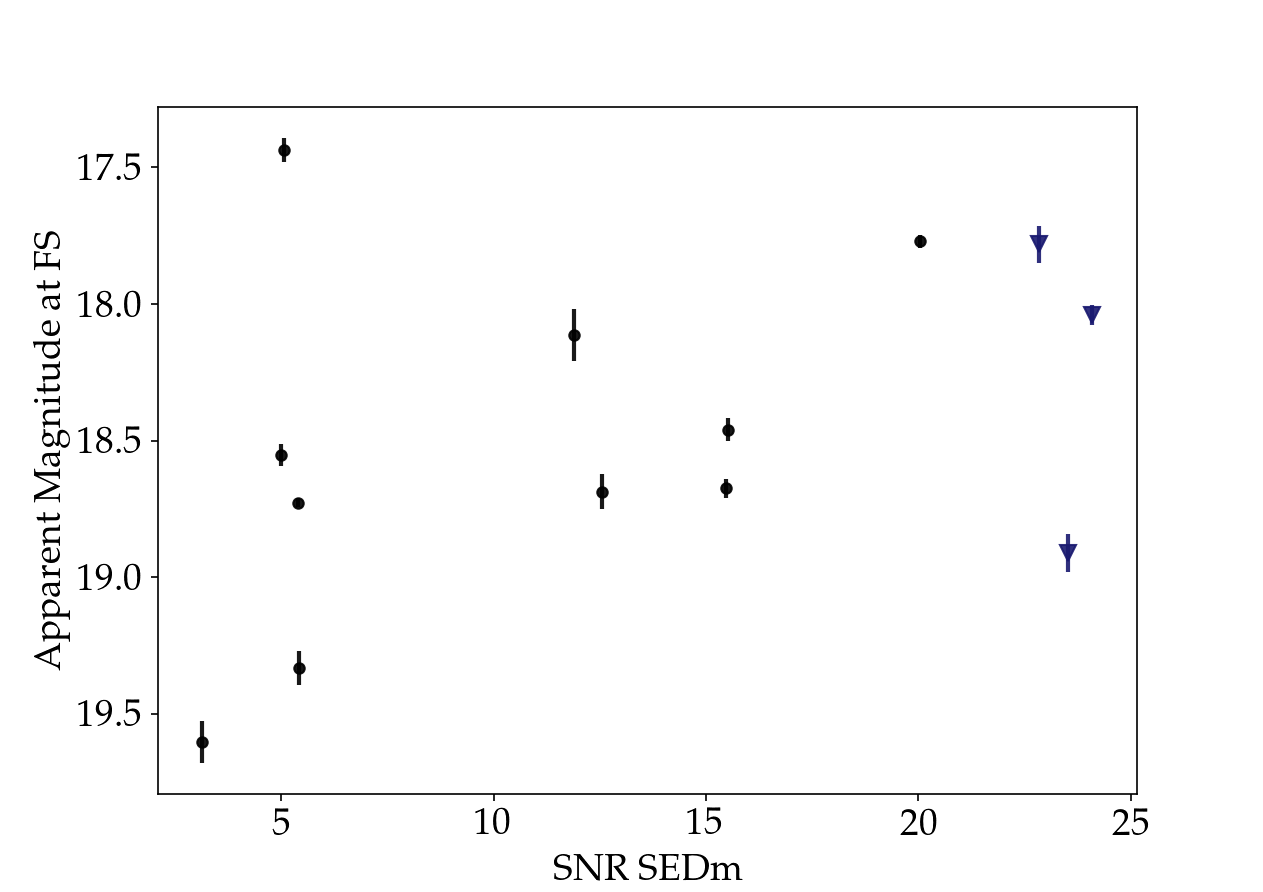

Text(0.5, 0, 'SNR SEDm')

In [90]:
plt.figure()
plt.errorbar(sedm_fs_ssnii['FS_SEDm_SNR'][:3], sedm_fs_ssnii['app_mag_g_at_FS'][:3], sedm_fs_ssnii['emagcorr_at_FS'][:3],
            fmt= 'v', alpha = 0.9,ms = 8 ,elinewidth=2,color = 'midnightblue')
plt.errorbar(sedm_fs_ssnii['FS_SEDm_SNR'][3:], sedm_fs_ssnii['app_mag_g_at_FS'][3:], sedm_fs_ssnii['emagcorr_at_FS'][3:],
            fmt= 'o', alpha = 0.9,ms = 5 ,elinewidth=2,color = 'black')

plt.gca().invert_yaxis()
plt.ylabel('Apparent Magnitude at FS', size = 18)
plt.xlabel('SNR SEDm', size = 18)

In [91]:
# plt.savefig('/Users/r.saturn/PhD/WIP/Full_RISNeII_ZTF1/figures/misc/app_mag_g_vs_snr_SEDm.pdf')

# Based on analysis below, we can discrimate a strong flashers down to an SNR of 5 and a weak flasher below 20

### STRONG FLASHERS NUMBERS

In [92]:
sedm_fs_ssnii[sedm_fs_ssnii['FS_SEDm_SNR']<5]

name,rach-classification,Flasher,First Detection,Last Non Detection,First Spectrum,app_mag_g_at_FS,emagcorr_at_FS,instrument-fs,FS_SEDm_SNR,ra_med,dec_med,redshift,e_redshift,z_ref,jd-redshift,instrument-redshift,UV,host,host_type,P-cygni,jd-pcyg,instrument-pcyg,t_exp,e_t_exp,jd_t_exp,Fs-Texp,peakabsmag_r,e_peakabsmag_r,peakday_r,e_peakday_r,peakabsmag_g,e_peakabsmag_g,peakday_g,e_peakday_g,decline_r,e_decline_r,decline_g,e_decline_g,climb_time_r,climb_time_g,EBV,extinction
str12,str10,str4,float64,float64,float64,float64,float64,str11,float64,float64,float64,float64,float64,str69,float64,str11,str4,str4,str12,str4,float64,str11,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
ZTF19aatqzrb,SN II,no,2458606.799,2458605.888,2458607.87,19.60388763881076,0.07541646783985895,SEDm+P60,3.146230618393122,221.652383,56.2342197,0.038136,9e-05,1988AJ.....95.1602S,--,--,no,yes,notype,no?,2458616.902,DBSP+P200,-0.01225465929,0.002565603556,2458606.787,1.08325466,-17.203746852930166,0.013660957745520251,17.561061757168286,0.729005380149389,-16.97636231923359,0.01592565259282788,10.330295126430208,0.9424960372674184,0.010127175501533262,0.0026255683466046543,0.02635034078202941,0.003927785695777718,13.29031357816509,5.845258530462861,0.014280407532998413,0.053541091835758635


In [93]:
strong_flasher_count = twoday_subsampSNII[twoday_subsampSNII['name']!='ZTF19aatqzrb']

In [94]:
ascii.write(strong_flasher_count, '/Users/r.saturn/PhD/WIP/Full_RISNeII_ZTF1/tables/StrongFlasher_2dsubsample_07042022.csv')

In [97]:
sedm_fs_ssnii[sedm_fs_ssnii['FS_SEDm_SNR']<15]

name,rach-classification,Flasher,First Detection,Last Non Detection,First Spectrum,app_mag_g_at_FS,emagcorr_at_FS,instrument-fs,FS_SEDm_SNR,ra_med,dec_med,redshift,e_redshift,z_ref,jd-redshift,instrument-redshift,UV,host,host_type,P-cygni,jd-pcyg,instrument-pcyg,t_exp,e_t_exp,jd_t_exp,Fs-Texp,peakabsmag_r,e_peakabsmag_r,peakday_r,e_peakday_r,peakabsmag_g,e_peakabsmag_g,peakday_g,e_peakday_g,decline_r,e_decline_r,decline_g,e_decline_g,climb_time_r,climb_time_g,EBV,extinction
str12,str10,str4,float64,float64,float64,float64,float64,str11,float64,float64,float64,float64,float64,str69,float64,str11,str4,str4,str12,str4,float64,str11,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
ZTF19aatqzrb,SN II,no,2458606.799,2458605.888,2458607.87,19.60388763881076,0.07541646783985895,SEDm+P60,3.146230618393122,221.652383,56.2342197,0.038136,9e-05,1988AJ.....95.1602S,--,--,no,yes,notype,no?,2458616.902,DBSP+P200,-0.01225465929,0.002565603556,2458606.787,1.08325466,-17.203746852930166,0.013660957745520251,17.561061757168286,0.729005380149389,-16.97636231923359,0.01592565259282788,10.330295126430208,0.9424960372674184,0.010127175501533262,0.0026255683466046543,0.02635034078202941,0.003927785695777718,13.29031357816509,5.845258530462861,0.014280407532998413,0.053541091835758635
ZTF19abbwfgp,SN II,no,2458661.82,2458660.843,2458663.759,17.436382944072598,0.044929189901271156,SEDm+P60,5.065131195413894,258.323795,43.7843194,0.025925,0.000117,1996AJ....112.1803M,--,--,no,yes,notype,yes,2458765.626,SEDm+P60,-0.003414843865,3.554028127,2458661.817,1.94241484,-18.186342251238855,0.014048037207915394,16.568761702761094,3.902908966038234,-18.320690934249058,0.012077415898528105,10.069203091028774,3.5684189048473307,0.010489959256260756,0.0008571756329513857,0.026363764932218915,0.0018966819703930445,8.963188294655511,6.870977314482737,0.014776554116459709,0.055401278929699475
ZTF19abrlvij,SN II,no,2458719.65,2458718.81,2458719.863,19.33221937426125,0.06254186346783698,SEDm+P60,5.429206536451919,260.142987,51.6327799,0.04737034239,0.001434140161,meas,2458780.673,DBSP+P200,yes,yes,--,yes,2458781.0,DBSP+P200,-0.8406629158,0.009803902951,2458718.809,1.05366292,-17.791342492213754,0.06614611436315786,10.220441432622941,0.40581480560957633,-17.66064111955716,0.06817193330860039,7.644293032604692,0.44709852181771625,0.014235298328977889,0.0033275365092662107,0.029569488704127327,0.006285098627985899,9.523976021510613,4.545650233313706,0.022734850300634733,0.08523907353524436
ZTF20aasfhia,SN II,no,2458912.78,2458911.97,2458913.818,18.686832148907357,0.06434413804180199,SEDm+P60,12.558027321771457,184.913045,33.0403926,0.04869508011,0.01474643786,meas,2458936.893,SEDm+P60,yes,no,--,yes?,2458936.893,SEDm+P60,-0.08261871974,0.01188694661,2458912.697,1.12061872,-18.177945794632286,0.6686043863886,11.415664797123556,1.2159240347124567,-18.422525524030988,0.6607434809286058,7.920384955373292,0.5639222901267563,0.015904280323571995,0.0016076446339417143,0.062486875594247544,0.00369506588537152,6.311393057452039,4.700437260904928,0.010539397832824262,0.03951503946626914
ZTF20abybeex,SN II,no,2459094.698,2459093.701,2459095.707,18.55150144254965,0.040554402905980926,SEDm+P60,5.007496092599176,260.769541,55.0724721,0.02777123985,0.003721313836,meas,2459099.636,DIS+APO,yes,yes,--,yes,2459107.651,SEDm+P60,-0.4984999998,0.4985,2459094.2,1.5075,-17.252981593792178,0.2932163239508694,11.10183610358126,2.116637939129005,-17.22160587930415,0.29500467668836566,6.535806495732165,0.978181596417952,0.0013700487509215474,0.0013391023032559438,0.019651911816197274,0.00282504782685908,6.842318946545993,3.3453374302067846,0.02997097669748646,0.11236925921473162
ZTF20acknpig,SN II,no,2459140.758,2459138.867,2459140.961,18.727075118659997,0.016826579733616568,SEDm+P60,5.394896923608213,30.7428678,45.0202856,0.024377,0.000103,1999ApJS..121..287H,--,--,yes,yes,S0/a,yes,2459144.644

## /!\ Double check that there's no HR spec afterwaards

In [100]:
delete_useless_spec = list(sedm_fs_ssnii[sedm_fs_ssnii['FS_SEDm_SNR']<15]['name'])

In [101]:
weak_flasher_count = vstack([x for x in twoday_subsampSNII if x['name'] not in delete_useless_spec])

In [102]:
weak_flasher_count

name,rach-classification,Flasher,classification,First Detection,Last Non Detection,First Spectrum,instrument-fs,fD-lND,fS-lND,ra_med,dec_med,redshift,e_redshift,z_ref,jd-redshift,instrument-redshift,UV,host,host_type,P-cygni,jd-pcyg,instrument-pcyg,t_exp,e_t_exp,jd_t_exp,Fs-Texp,peakabsmag_r,e_peakabsmag_r,peakday_r,e_peakday_r,peakabsmag_g,e_peakabsmag_g,peakday_g,e_peakday_g,decline_r,e_decline_r,decline_g,e_decline_g,climb_time_r,climb_time_g
str12,str10,str4,str6,float64,float64,float64,str11,float64,float64,float64,float64,float64,float64,str69,float64,str11,str4,str4,str12,str4,float64,str11,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
ZTF18abckutn,SN II,no,SN IIP,2458289.865,2458289.758,2458290.748,DBSP+P200,0.1074884,0.99028249,237.026897,55.7148553,0.040705,0.000123,1999PASP..111..438F,--,--,yes,yes,notype,yes,2458307.69,DBSP+P200,-0.1069391354,0.01501290292,2458289.758,0.98993913,-17.489833262081575,0.00961684735079223,16.19256326104363,0.29419405502410373,-17.511123656906882,0.014952041887626596,9.522573088435623,0.6234607506231766,0.008576205724715288,0.001859420359141762,0.029699745465459428,0.0059168450289302996,9.330205161421391,6.232506273806587
ZTF18abdbysy,SN II,yes?,SN IIP,2458295.705,2458294.781,2458296.4,ACAM+WHT,0.9234606,1.6180685,233.535367,56.6968577,0.012122,0.000175,2005SDSS4.C...0000:,--,--,yes,yes,notype,yes,2458334.75,DBSP+P200,-0.9810973016,0.001930022149,2458294.724,1.6760973,-15.49331020545953,0.0331526327068752,16.85753795836716,0.2862893468098687,-14.505103984137875,0.03272188124838144,10.372182527968567,0.3033303606071478,0.011610440903574113,0.0013302220278154035,0.03011464940724035,0.007192822166535693,10.821940937539091,7.09928796409179
ZTF18abeajml,SN II,yes,SN II,2458303.799,2458302.797,2458304.794,SEDm+P60,1.0019,1.99674769,252.03236,24.3040949,0.036526,8.6e-05,2005SDSS4.C...0000:,--,--,yes,yes,notype,yes,2458331.71,SEDm+P60,-0.02632267313,1.331885814,2458303.773,1.02132267,-18.50264443512861,0.015414958320710454,10.42687184147541,1.5013246095658397,-18.549787640366937,0.007498228090990184,7.372101208620604,1.351557480278869,0.0204867406038592,0.0009898916851182882,0.03619533929041421,0.0026608903799914055,6.572604715042432,4.575926693168947
ZTF18abgqvwv,SN II,yes?,SN IIP,2458313.73,2458312.838,2458314.569,ISIS+WHT,0.8915,1.73143,254.316401,31.9631992,0.037726,9.7e-05,2004SDSS3.C...0000:,--,--,no,yes,notype,yes,2458351.82,DBSP+P200,-1.02018285,0.001249450749,2458312.71,1.85918285,-16.814019840514156,0.006961016565343625,16.7395086276049,0.780814570522296,-16.656944283657296,0.030287354900355737,5.723185790692419,0.6022522133450261,-0.002767699609499243,0.0017236495965795575,0.0069464632463789545,0.0022731549446064706,14.424816825463473,4.47988680579762
ZTF18abokyfk,SN II,yes,SN II,2458350.89,2458349.901,2458352.006,DBSP+P200,0.9891898,2.10471592,2.360629,47.3540827,0.017189,3.3e-05,1999ApJS..121..287H,--,--,yes,yes,Sbc,yes,2458470.335,ACAM+WHT,-0.01311684685,0.00810257263,2458350.877,1.12911685,-17.17781792076166,0.008184648340751678,14.129301377718392,1.0319524497021388,-17.01907663711989,0.0332647297080407,10.042441351563802,1.685214752840058,0.005844303818708419,0.0014540596351276867,0.026480640502759393,0.0014649410130147898,10.31568752100516,6.276399839859646
ZTF18abwlsoi,SN II,yes,SN II,2458377.63,2458376.74,2458377.751,SEDm+P60,0.8952,1.0131723,261.897614,71.530251,0.05376479944,0.007318710553,meas,2458443.6,SEDm+P60,no,yes,--,yes,2458443.6,SEDm+P60,-0.02146235453,0.002665623404,2458377.609,0.14246235,-18.518220748706636,0.29569547023108217,6.291511375496778,0.3851094457398963,-18.581476347170103,0.2963036637351274,4.884686383300792,0.285709373570058,0.031614797151004376,0.008121157616170814,0.045954074587724325,0.007425436176296284,4.868515110202693,3.165895028481702
ZTF18acqwdla,SN II,no,SN II,2458443.874,2458443.789,2458443.937,SEDm+P60,0.0855324,0.1481347,106.472662,12.8929375,

In [103]:
ascii.write(weak_flasher_count, '/Users/r.saturn/PhD/WIP/Full_RISNeII_ZTF1/tables/WeakFlasher_2dsubsample_07042022.csv')

In [519]:
twoday_subsampSNII.show_in_notebook()

idx,name,rach-classification,Flasher,classification,First Detection,Last Non Detection,First Spectrum,instrument-fs,fD-lND,fS-lND,ra_med,dec_med,redshift,e_redshift,z_ref,jd-redshift,instrument-redshift,UV,host,host_type,P-cygni,jd-pcyg,instrument-pcyg,t_exp,e_t_exp,jd_t_exp,Fs-Texp,peakabsmag_r,e_peakabsmag_r,peakday_r,e_peakday_r,peakabsmag_g,e_peakabsmag_g,peakday_g,e_peakday_g,decline_r,e_decline_r,decline_g,e_decline_g,climb_time_r,climb_time_g
0,ZTF18abckutn,SN II,no,SN IIP,2458289.865,2458289.758,2458290.748,DBSP+P200,0.1074884,0.99028249,237.026897,55.7148553,0.040705,0.000123,1999PASP..111..438F,--,--,yes,yes,notype,yes,2458307.69,DBSP+P200,-0.1069391354,0.01501290292,2458289.758,0.98993913,-17.489833262081575,0.00961684735079223,16.19256326104363,0.29419405502410373,-17.511123656906882,0.014952041887626596,9.522573088435623,0.6234607506231766,0.008576205724715288,0.001859420359141762,0.029699745465459428,0.0059168450289302996,9.330205161421391,6.232506273806587
1,ZTF18abdbysy,SN II,yes?,SN IIP,2458295.705,2458294.781,2458296.4,ACAM+WHT,0.9234606,1.6180685,233.535367,56.6968577,0.012122,0.000175,2005SDSS4.C...0000:,--,--,yes,yes,notype,yes,2458334.75,DBSP+P200,-0.9810973016,0.001930022149,2458294.724,1.6760973,-15.49331020545953,0.0331526327068752,16.85753795836716,0.2862893468098687,-14.505103984137875,0.03272188124838144,10.372182527968567,0.3033303606071478,0.011610440903574113,0.0013302220278154035,0.03011464940724035,0.007192822166535693,10.821940937539091,7.09928796409179
2,ZTF18abeajml,SN II,yes,SN II,2458303.799,2458302.797,2458304.794,SEDm+P60,1.0019,1.99674769,252.03236,24.3040949,0.036526,8.6e-05,2005SDSS4.C...0000:,--,--,yes,yes,notype,yes,2458331.71,SEDm+P60,-0.02632267313,1.331885814,2458303.773,1.02132267,-18.50264443512861,0.015414958320710454,10.42687184147541,1.5013246095658397,-18.549787640366937,0.007498228090990184,7.372101208620604,1.351557480278869,0.0204867406038592,0.0009898916851182882,0.03619533929041421,0.0026608903799914055,6.572604715042432,4.575926693168947
3,ZTF18abgqvwv,SN II,yes?,SN IIP,2458313.73,2458312.838,2458314.569,ISIS+WHT,0.8915,1.73143,254.316401,31.9631992,0.037726,9.7e-05,2004SDSS3.C...0000:,--,--,no,yes,notype,yes,2458351.82,DBSP+P200,-1.02018285,0.001249450749,2458312.71,1.85918285,-16.814019840514156,0.006961016565343625,16.7395086276049,0.780814570522296,-16.656944283657296,0.030287354900355737,5.723185790692419,0.6022522133450261,-0.002767699609499243,0.0017236495965795575,0.0069464632463789545,0.0022731549446064706,14.424816825463473,4.47988680579762
4,ZTF18abokyfk,SN II,yes,SN II,2458350.89,2458349.901,2458352.006,DBSP+P200,0.9891898,2.10471592,2.360629,47.3540827,0.017189,3.3e-05,1999ApJS..121..287H,--,--,yes,yes,Sbc,yes,2458470.335,ACAM+WHT,-0.01311684685,0.00810257263,2458350.877,1.12911685,-17.17781792076166,0.008184648340751678,14.129301377718392,1.0319524497021388,-17.01907663711989,0.0332647297080407,10.042441351563802,1.685214752840058,0.005844303818708419,0.0014540596351276867,0.026480640502759393,0.0014649410130147898,10.31568752100516,6.276399839859646
5,ZTF18abwlsoi,SN II,yes,SN II,2458377.63,2458376.74,2458377.751,SEDm+P60,0.8952,1.0131723,261.897614,71.530251,0.05376479944,0.007318710553,meas,2458443.6,SEDm+P60,no,yes,--,yes,2458443.6,SEDm+P60,-0.02146235453,0.002665623404,2458377.609,0.14246235,-18.518220748706636,0.29569547023108217,6.291511375496778,0.3851094457398963,-18.581476347170103,0.2963036637351274,4.884686383300792,0.285709373570058,0.031614797151004376,0.008121157616170814,0.045954074587724325,0.007425436176296284,4.868515110202693,3.165895028481702
6,ZTF18acqwdla,SN II,no,SN II,2458443.874,2458443.789,2458443.937,SEDm+P60,0.0855324,0.1481347,106.472662,12.8929375,0.026212141,0.004739291488,meas,2458616.456,EFOSC2+NTT,no,yes,--,yes,2458616.456,EFOSC2+NTT,-0.04249999998,0.04249999998,2458443.832,0.1055,-18.60137684700958,0.39262836644613214,12.183829851753528,1.2991954919750475,-18.754296156407,0.39288470141123233,11.513745758265994,0.385908

## SIMULATING FLASH SPECTRA FOR SEDM 

## From a perfect template

We consider  1 order of magnitude difference of mass loss. Same progenitor properties. We consider the 10-2 mass loss as a strong flasher

<IPython.core.display.Javascript object>


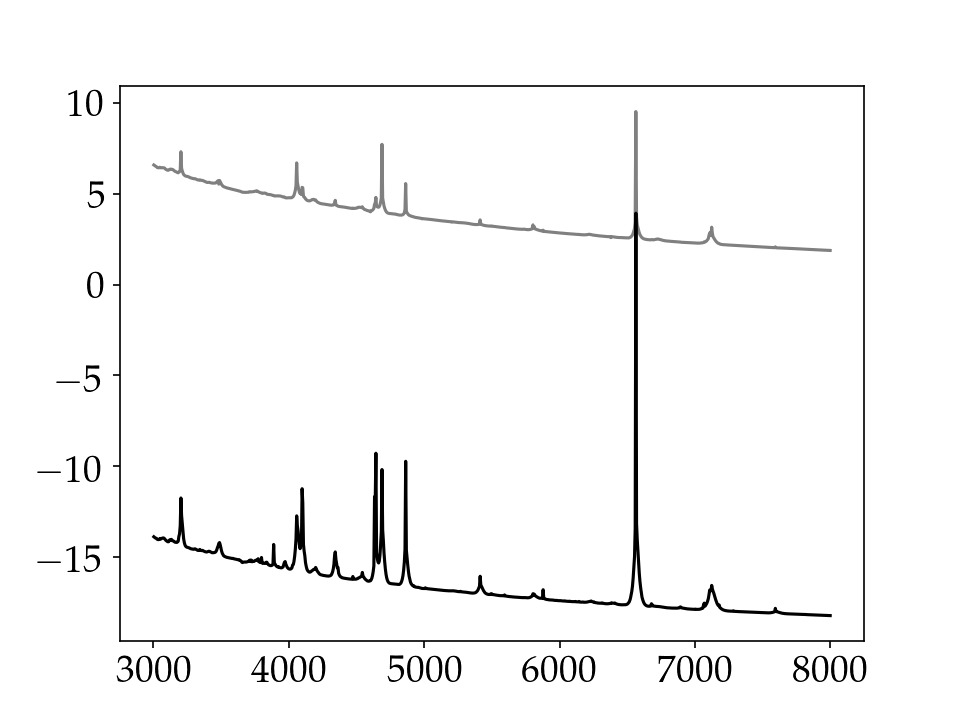

In [21]:
testemp1 = ascii.read('/Users/r.saturn/Dropbox (Weizmann Institute)/PhD/WIP/Flashers/boian_templates/CNO/L1.5e9_Mdot1e-3_Vinf150_R8e13_cno.dat') 
testemp2 = ascii.read('/Users/r.saturn/Dropbox (Weizmann Institute)/PhD/WIP/Flashers/boian_templates/CNO/L1.5e9_Mdot3e-3_Vinf150_R8e13_cno.dat')

# testemp2 = ascii.read('/Users/r.saturn/PhD/WIP/Flashers/boian_templates/CNO/L1.5e9_Mdot1e-2_Vinf150_R8e13_cno.dat')


testemp1 = testemp1[(testemp1['col1']>=3000) & (testemp1['col1']<=8000)]
testemp2 = testemp2[(testemp2['col1']>=3000) & (testemp2['col1']<=8000)]

plt.figure()
plt.plot(testemp1['col1'], testemp1['col2'], color = 'grey')
plt.plot(testemp2['col1'], testemp2['col2']-20, color = 'black')

In [22]:
# 

spek11   = pyasl.instrBroadGaussFast(testemp1['col1'], testemp1['col2'], 100, edgeHandling='firstlast', fullout=False, maxsig=None)
spek12   = pyasl.instrBroadGaussFast(testemp1['col1'], testemp1['col2'], 390, edgeHandling='firstlast', fullout=False, maxsig=None)
# spek3   = pyasl.instrBroadGaussFast(testemp['col1'], testemp['col2'], 500, edgeHandling='firstlast', fullout=False, maxsig=None)



spek21   = pyasl.instrBroadGaussFast(testemp2['col1'], testemp2['col2'], 100, edgeHandling='firstlast', fullout=False, maxsig=None)
spek22   = pyasl.instrBroadGaussFast(testemp2['col1'], testemp2['col2'], 390, edgeHandling='firstlast', fullout=False, maxsig=None)
# spek3   = pyasl.instrBroadGaussFast(testemp['col1'], testemp['col2'], 500, edgeHandling='firstlast', fullout=False, maxsig=None)





In [23]:
testemp1['convSEDm']  = spek11
testemp1['convNTT']   = spek12

testemp2['convSEDm']  = spek21
testemp2['convNTT']   = spek22



# testemp['convDeepSpec']   = spek3

### Injecting a variety of noise levels in the spectra

starting with the weak mass loss

In [40]:
binned_sedm1       = bin_spectra(testemp1['col1'],testemp1['convSEDm'], 30 )

166
the spectra is binned for a resolution of 30


In [55]:
# SNR 30
bin_noise_sedm1_30 = noise_spec(35, binned_sedm1)

sedm1_noise_30      = Table(data = [binned_sedm1['bin_wl'],bin_noise_sedm1_30],names = ('wl','flux'))
print(f'SNR is {estimate_snr_over_band(sedm1_noise_30,bandpass = [5900,6300])}')

SNR is 31.323138339210043


In [64]:
# SNR 20
bin_noise_sedm1_20 = noise_spec(20, binned_sedm1)

sedm1_noise_20      = Table(data = [binned_sedm1['bin_wl'],bin_noise_sedm1_20],names = ('wl','flux'))
print(f'SNR is {estimate_snr_over_band(sedm1_noise_20,bandpass = [5900,6300])}')

SNR is 19.726550210208103


In [89]:
bin_noise_sedm1_15 = noise_spec(15, binned_sedm1)

sedm1_noise_15      = Table(data = [binned_sedm1['bin_wl'],bin_noise_sedm1_15],names = ('wl','flux'))
print(f'SNR is {estimate_snr_over_band(sedm1_noise_15,bandpass = [5900,6300])}')

SNR is 15.614437507359966


In [95]:
bin_noise_sedm1_10 = noise_spec(10, binned_sedm1)

sedm1_noise_10      = Table(data = [binned_sedm1['bin_wl'],bin_noise_sedm1_10],names = ('wl','flux'))
print(f'SNR is {estimate_snr_over_band(sedm1_noise_10,bandpass = [5900,6300])}')

SNR is 10.608923457605478


In [97]:
bin_noise_sedm1_5  = noise_spec(5,  binned_sedm1)

sedm1_noise_5      = Table(data = [binned_sedm1['bin_wl'],bin_noise_sedm1_5],names = ('wl','flux'))
print(f'SNR is {estimate_snr_over_band(sedm1_noise_5,bandpass = [5900,6300])}')

SNR is 5.18514417922402


continue with stronger massloss (3e-3modot/yr)

In [115]:
binned_sedm2    = bin_spectra(testemp2['col1'],testemp2['convSEDm'], 30 )

166
the spectra is binned for a resolution of 30


In [132]:
bin_noise_sedm2_30 = noise_spec(30, binned_sedm2)

sedm2_noise_30      = Table(data = [binned_sedm2['bin_wl'],bin_noise_sedm2_30],names = ('wl','flux'))
print(f'SNR is {estimate_snr_over_band(sedm2_noise_30,bandpass = [5900,6300])}')


SNR is 30.53793058227324


In [135]:
bin_noise_sedm2_20 = noise_spec(20, binned_sedm2)

sedm2_noise_20      = Table(data = [binned_sedm2['bin_wl'],bin_noise_sedm2_20],names = ('wl','flux'))
print(f'SNR is {estimate_snr_over_band(sedm2_noise_20,bandpass = [5900,6300])}')


SNR is 20.940079011388935


In [140]:
bin_noise_sedm2_15 = noise_spec(15, binned_sedm2)

sedm2_noise_15      = Table(data = [binned_sedm2['bin_wl'],bin_noise_sedm2_15],names = ('wl','flux'))
print(f'SNR is {estimate_snr_over_band(sedm2_noise_15,bandpass = [5900,6300])}')


SNR is 15.79127822577673


In [141]:
bin_noise_sedm2_10 = noise_spec(10, binned_sedm2)

sedm2_noise_10      = Table(data = [binned_sedm2['bin_wl'],bin_noise_sedm2_10],names = ('wl','flux'))
print(f'SNR is {estimate_snr_over_band(sedm2_noise_10,bandpass = [5900,6300])}')


SNR is 9.337581271154097


In [142]:
bin_noise_sedm2_5  = noise_spec(5,  binned_sedm2)

sedm2_noise_5      = Table(data = [binned_sedm2['bin_wl'],bin_noise_sedm2_5],names = ('wl','flux'))
print(f'SNR is {estimate_snr_over_band(sedm2_noise_5,bandpass = [5900,6300])}')


SNR is 5.297849717882664


In [144]:
bin_noise_sedm2_3  = noise_spec(3,  binned_sedm2)

sedm2_noise_3      = Table(data = [binned_sedm2['bin_wl'],bin_noise_sedm2_3],names = ('wl','flux'))
print(f'SNR is {estimate_snr_over_band(sedm2_noise_3,bandpass = [5900,6300])}')


SNR is 2.876258145415864


<IPython.core.display.Javascript object>


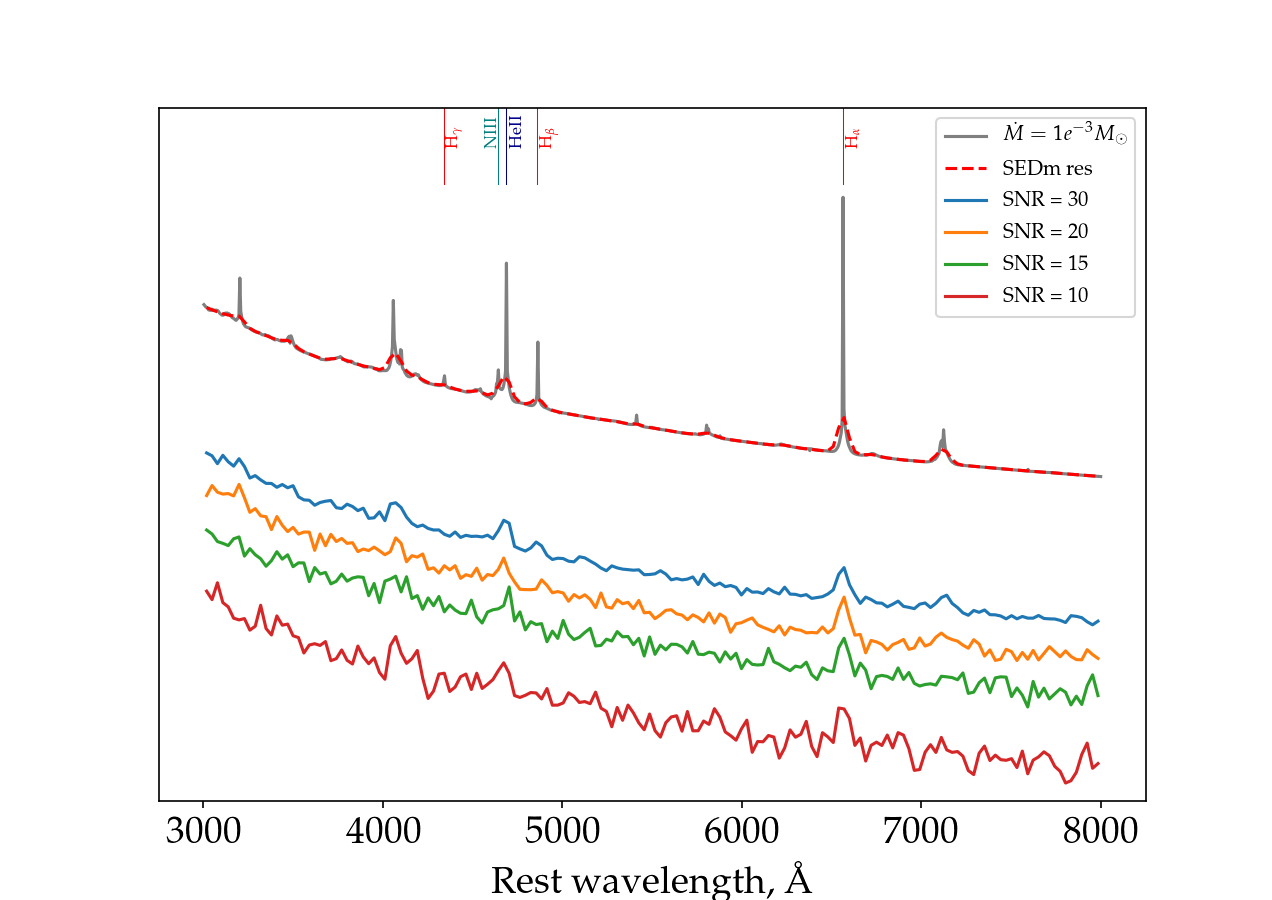

(-5, 14)

In [145]:
plt.figure(figsize = (6*np.sqrt(2),6))
plt.plot(testemp1['col1'], testemp1['col2']+2, color = 'grey', label = '$\dot{M} = 1e^{-3} M_{\odot}$ ')
plt.plot(binned_sedm1['bin_wl'], binned_sedm1['bin_flux']+2, ls = '--',color = 'red',label = 'SEDm res' )

plt.plot(binned_sedm1['bin_wl'], bin_noise_sedm1_30 -2, label = 'SNR = 30')
plt.plot(binned_sedm1['bin_wl'], bin_noise_sedm1_20 -3, label = 'SNR = 20')
plt.plot(binned_sedm1['bin_wl'], bin_noise_sedm1_15 -4, label = 'SNR = 15')
plt.plot(binned_sedm1['bin_wl'], bin_noise_sedm1_10 -6, label = 'SNR = 10')
# plt.plot(binned_sedm1['bin_wl'], bin_noise_sedm1_5 -9, label = 'SNR = 5')


plt.axvline(4686,ymin  = 0.89, ymax = 1, color = 'darkblue', lw = 0.5)
plt.text(4686+20, 13, 'HeII', rotation = 90, color = 'darkblue', size = 8)


plt.axvline(6563, ymin  = 0.89, ymax = 1, color = 'red', lw = 0.5)
plt.text(6563+20, 13, r'H$_{\alpha}$', rotation = 90, color = 'red', size = 8)

plt.axvline(4861, ymin  = 0.89, ymax = 1,color = 'red', lw = 0.5)
plt.text(4861+20, 13, r'H$_{\beta}$', rotation = 90, color = 'red', size = 8)
plt.axvline(4341, ymin  = 0.89, ymax = 1,color = 'red', lw = 0.5)
plt.text(4341+20, 13, r'H$_{\gamma}$', rotation = 90, color = 'red', size = 8)

plt.axvline(4641, ymin  = 0.89, ymax = 1,color = 'teal', lw = 0.5)
plt.text(4641-70, 13, 'NIII', rotation = 90, color = 'teal', size = 8)

plt.yticks([])
plt.legend()
plt.xlabel('Rest wavelength, Å', size = 18)

plt.ylim([-5,14])

In [147]:
plt.savefig('/Users/r.saturn/Dropbox (Weizmann Institute)/PhD/WIP/Full_RISNeII_ZTF1/figures/flasher_statistics/weak_flasher_vs_sedm.pdf')

<IPython.core.display.Javascript object>


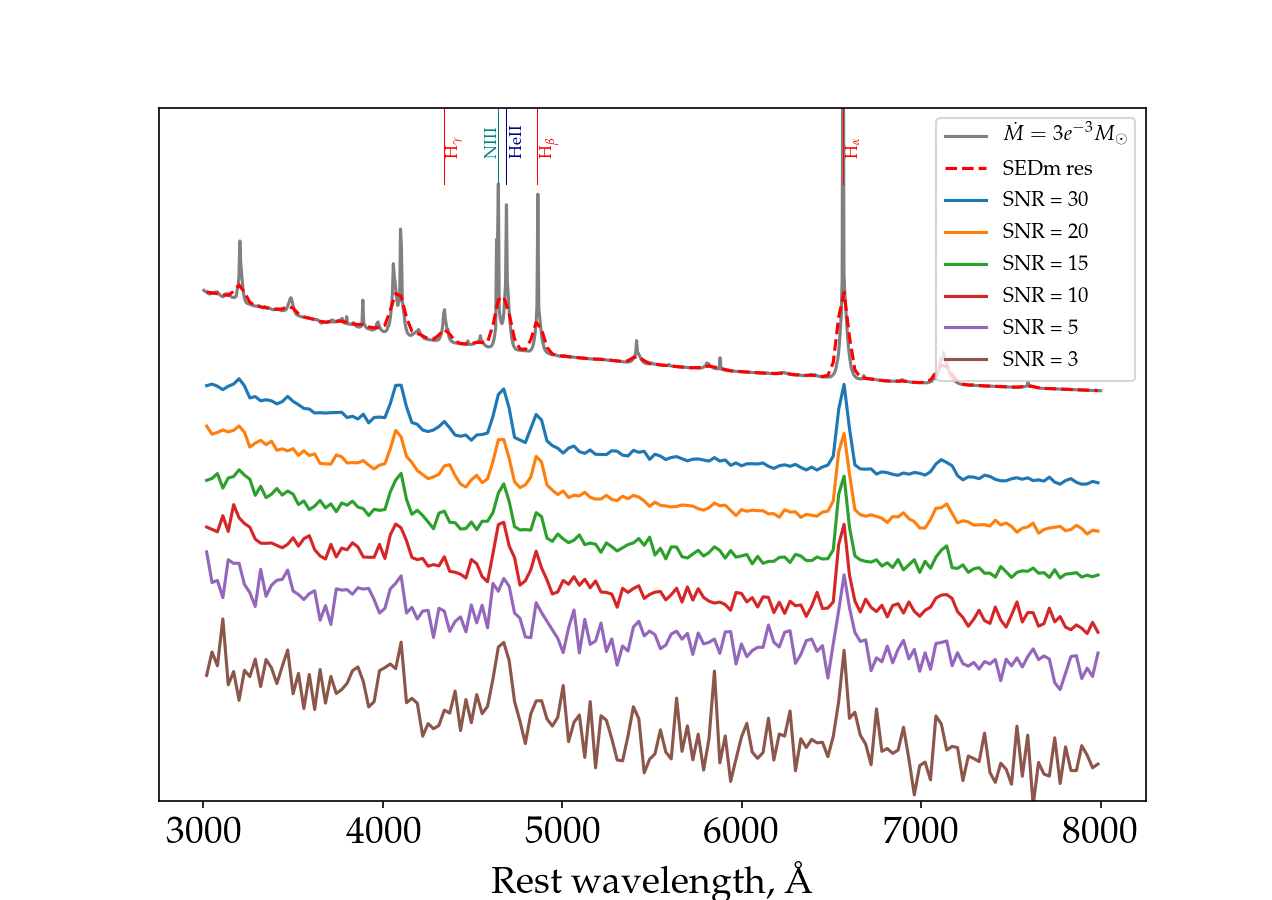

(-15, 15)

In [153]:
plt.figure(figsize = (6*np.sqrt(2),6))
plt.plot(testemp2['col1'], testemp2['col2']+1, color = 'grey', label = '$\dot{M} = 3e^{-3} M_{\odot}$ ' )
plt.plot(binned_sedm2['bin_wl'], binned_sedm2['bin_flux']+1, ls = '--',color = 'red',label = 'SEDm res')



plt.plot(binned_sedm2['bin_wl'], bin_noise_sedm2_30 -3, label = 'SNR = 30')
plt.plot(binned_sedm2['bin_wl'], bin_noise_sedm2_20 -5, label = 'SNR = 20')
plt.plot(binned_sedm2['bin_wl'], bin_noise_sedm2_15 -7,  label = 'SNR = 15')
plt.plot(binned_sedm2['bin_wl'], bin_noise_sedm2_10 -9,  label = 'SNR = 10')
plt.plot(binned_sedm2['bin_wl'], bin_noise_sedm2_5 -11,  label = 'SNR = 5')
plt.plot(binned_sedm2['bin_wl'], bin_noise_sedm2_3 -15,  label = 'SNR = 3')




plt.axvline(4686,ymin  = 0.89, ymax = 1, color = 'darkblue', lw = 0.5)
plt.text(4686+20, 13, 'HeII', rotation = 90, color = 'darkblue', size = 8)


plt.axvline(6563, ymin  = 0.89, ymax = 1, color = 'red', lw = 0.5)
plt.text(6563+20, 13, r'H$_{\alpha}$', rotation = 90, color = 'red', size = 8)

plt.axvline(4861, ymin  = 0.89, ymax = 1,color = 'red', lw = 0.5)
plt.text(4861+20, 13, r'H$_{\beta}$', rotation = 90, color = 'red', size = 8)
plt.axvline(4341, ymin  = 0.89, ymax = 1,color = 'red', lw = 0.5)
plt.text(4341+20, 13, r'H$_{\gamma}$', rotation = 90, color = 'red', size = 8)

plt.axvline(4641, ymin  = 0.89, ymax = 1,color = 'teal', lw = 0.5)
plt.text(4641-70, 13, 'NIII', rotation = 90, color = 'teal', size = 8)

plt.yticks([])
plt.legend()
plt.xlabel('Rest wavelength, Å', size = 18)

plt.ylim([-15,15])


In [155]:
plt.savefig('/Users/r.saturn/Dropbox (Weizmann Institute)/PhD/WIP/Full_RISNeII_ZTF1/figures/flasher_statistics/strong_flasher_vs_sedm.pdf')

## Conclusion 

For strong flashers, the SNR cut for SEDm is whichever is below 5. For weak flashers, the SNR cut is below 20 (15 to be conservative)

## Degrading a HR spec to SEDm res 

In [214]:
HR_spec = twoday_subsampSNII[twoday_subsampSNII['instrument-fs']!='SEDm+P60']

In [215]:
HR_spec_flash = HR_spec[HR_spec['Flasher']=='yes']

In [216]:
HR_spec_flash

name,rach-classification,Flasher,classification,First Detection,Last Non Detection,First Spectrum,instrument-fs,fD-lND,fS-lND,ra_med,dec_med,redshift,e_redshift,z_ref,jd-redshift,instrument-redshift,UV,host,host_type,P-cygni,jd-pcyg,instrument-pcyg,t_exp,e_t_exp,jd_t_exp,Fs-Texp,peakabsmag_r,e_peakabsmag_r,peakday_r,e_peakday_r,peakabsmag_g,e_peakabsmag_g,peakday_g,e_peakday_g,decline_r,e_decline_r,decline_g,e_decline_g,climb_time_r,climb_time_g
str12,str10,str4,str6,float64,float64,float64,str11,float64,float64,float64,float64,float64,float64,str69,float64,str11,str4,str4,str12,str4,float64,str11,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
ZTF18abokyfk,SN II,yes,SN II,2458350.89,2458349.901,2458352.006,DBSP+P200,0.9891898,2.10471592,2.360629,47.3540827,0.017189,3.3e-05,1999ApJS..121..287H,--,--,yes,yes,Sbc,yes,2458470.335,ACAM+WHT,-0.01311684685,0.00810257263,2458350.877,1.12911685,-17.17781792076166,0.008184648340751678,14.129301377718392,1.0319524497021388,-17.01907663711989,0.0332647297080407,10.042441351563802,1.685214752840058,0.005844303818708419,0.0014540596351276867,0.026480640502759393,0.0014649410130147898,10.31568752100516,6.276399839859646
ZTF19abueupg,SN II,yes,SN II,2458724.65,2458723.81,2458725.0,KAST+Lick,0.8381,1.05203241,267.80329,51.3825496,0.017,0.005,superfit,2458728.5,KAST+Lick,yes,yes,--,no?,2458726.867,LRIS+Keck,-0.06598457236,0.01248434827,2458724.584,0.41598457,-16.95681076130405,0.3773607420941401,7.308715897967324,0.24736832618732948,-17.02767166159192,0.37741020899787786,7.090234361829822,0.3435141398378344,0.004205001496146869,0.0016525030563393777,0.023564288696171647,0.0033249787331478004,6.125237700242728,5.283687875084523
ZTF19acryurj,SN II,yes,SN II,2458800.79,2458799.805,2458801.991,GMOS+Gemini,0.9845,2.18556632,13.5933959,31.6701819,0.022035,3e-05,1999PASP..111..438F,--,--,yes,yes,Scd,yes,2458851.68,SEDm+P60,-0.7930354097,0.03180023974,2458799.997,1.99403541,-18.174868362848947,0.019641623004026457,12.474288294860525,1.653309210781393,-18.020185604926763,0.002957939871472252,15.14928994756515,0.11212448745559071,0.01811168499078665,0.0008267861935223747,0.035946359943563766,0.0012075309354014595,8.863190847760377,9.130079328154752
ZTF20ablygyy,SN II,yes,SN II,2459046.698,2459045.754,2459047.403,DOLORES+TNG,0.9434,1.64900626,225.958184,42.1140315,0.016872,2.3e-05,1993A&AS..102...57B,--,--,yes,yes,Sbab,yes,2459114.661,SEDm+P60,-0.1589595728,0.03148805308,2459046.539,0.86395957,-18.247998349089393,0.010482662682663664,11.01065398248554,0.27187684849252963,-18.265771872920766,0.004435145395014,6.268145184466201,0.5263487480959356,0.02933718847128311,0.0011283151366253737,0.029054072514433423,0.002394936123568392,7.190677980323218,4.608315096647424
ZTF20abqwkxs,SN II,yes,SN II,2459070.704,2459069.799,2459072.391,DOLORES+TNG,0.9044,2.5917425,224.868111,73.8986784,0.023903,7.3e-05,1999PASP..111..438F,--,--,yes,yes,SB( rs )b,yes,2459106.36,ALFOSC+NOT,-0.0059537608,0.02928073503,2459070.698,1.69295376,-15.882131526378505,0.008152407406464597,6.257557109518112,0.9150995631946598,-15.942872987745261,0.011461420029917421,4.718539994470884,0.5506076857442014,0.005031654343084986,0.009549441484546353,0.02348211608489761,0.010991320559639962,4.95901176473825,2.435593317404531
ZTF20abxyjtx,SN II,yes,SN II,2459093.634,2459091.716,2459094.375,ALFOSC+NOT,1.9185,2.65930737,236.937978,28.6403193,0.033224,7.4e-05,2005SDSS4.C...0000:,--,--,yes,yes,Sc,yes?,2459109.71,SEDm+P60,-0.1503734545,0.008119565927,2459093.484,0.89137345,-17.874252686716996,0.2930944493524925,12.370434607127184,1.5730743903924373,99.0,99.0,99.0,99.0,0.02515258671397581,0.0028321342239474266,99.0,99.0,99.0,99.0


## ZTF19acryurj

In [272]:
len(urj)

3158

In [495]:
urj = ascii.read('/Volumes/Machiavelli/WIP/Full_Infant_SNeII/data/2019/ZTF19acryurj/spectroscopy/ZTF19acryurj_20191114_Gemini_N_v1.ascii',
                              names = ['wl','flux'])
# urj['flux'] /= np.median(urj[(urj['wl']<6000)&(urj['wl']>5000)]['flux'])

In [496]:
urj = correct_spectrum('ZTF19acryurj',urj)

In [497]:
estimate_snr_over_band(urj, bandpass=[4100,4500])

22.96857073867873

In [498]:
interp_flux = interp1d(urj['wl'], urj['flux'] ,  bounds_error=False, fill_value='nan')
interp_wl   = np.linspace(min(urj['wl']), max(urj['wl']), 4000)

sedm_urj_sim = Table(data=([interp_wl,interp_flux(interp_wl)]), names = ('wl', 'flux'))

In [499]:


spek1   = pyasl.instrBroadGaussFast(sedm_urj_sim['wl'], sedm_urj_sim['flux'], 100, edgeHandling='firstlast', fullout=False, maxsig=None)
sedm_urj_sim['convSEDm']  = spek1


binned_sedm    = bin_spectra(sedm_urj_sim['wl'],sedm_urj_sim['convSEDm'], 30 )

104
the spectra is binned for a resolution of 30


In [500]:
noised_flux_Sedm = noise_spec(snr = 23, spec = binned_sedm, bandpass=[4100,4500])
binned_sedm['noised_flux'] = noised_flux_Sedm

In [501]:
estimate_snr_over_band(binned_sedm, bandpass=[4100,4500])

29.45687162753354

In [502]:
var_sedmsim       = np.var(binned_sedm[(binned_sedm['bin_wl']>=4100)&(binned_sedm['bin_wl']<=4500)]['noised_flux'])

test_snr_sedm_sim = binned_sedm[(binned_sedm['bin_wl']>=4100)&(binned_sedm['bin_wl']<=4500)]

urj_snr_semdsim   = np.nanmedian(test_snr_sedm_sim['noised_flux']/np.sqrt(var_sedmsim))

In [503]:
urj_snr_semdsim

22.430374374214757

In [243]:
# target    = snr*np.sqrt(var) 
# mean_flux = np.average( spec[(spec['bin_wl']>=4100)&(spec['bin_wl']<=5500)]['bin_flux'] )

# # Generate an sample of white noise
# sigma_noise = target - mean_flux

# mean_noise = 0
# noise      = np.random.normal(mean_noise, np.sqrt(sigma_noise), len(flux))

In [504]:
real_sedm_urj = ascii.read('/Volumes/Machiavelli/WIP/Full_Infant_SNeII/data/2019/ZTF19acryurj/spectroscopy/ZTF19acryurj_20191115_P60_v1.ascii',
                          names = ['wl','flux','var'])

In [505]:
real_sedm_urj = correct_spectrum('ZTF19acryurj',real_sedm_urj)

In [506]:
var     = np.var(real_sedm_urj[(real_sedm_urj['wl']>=4100)&(real_sedm_urj['wl']<=4500)]['flux'])

test_snr = real_sedm_urj[(real_sedm_urj['wl']>=4100)&(real_sedm_urj['wl']<=4500)]

urj_snr = np.nanmedian(test_snr['flux']/np.sqrt(var))
urj_snr

14.523765859694864

<IPython.core.display.Javascript object>


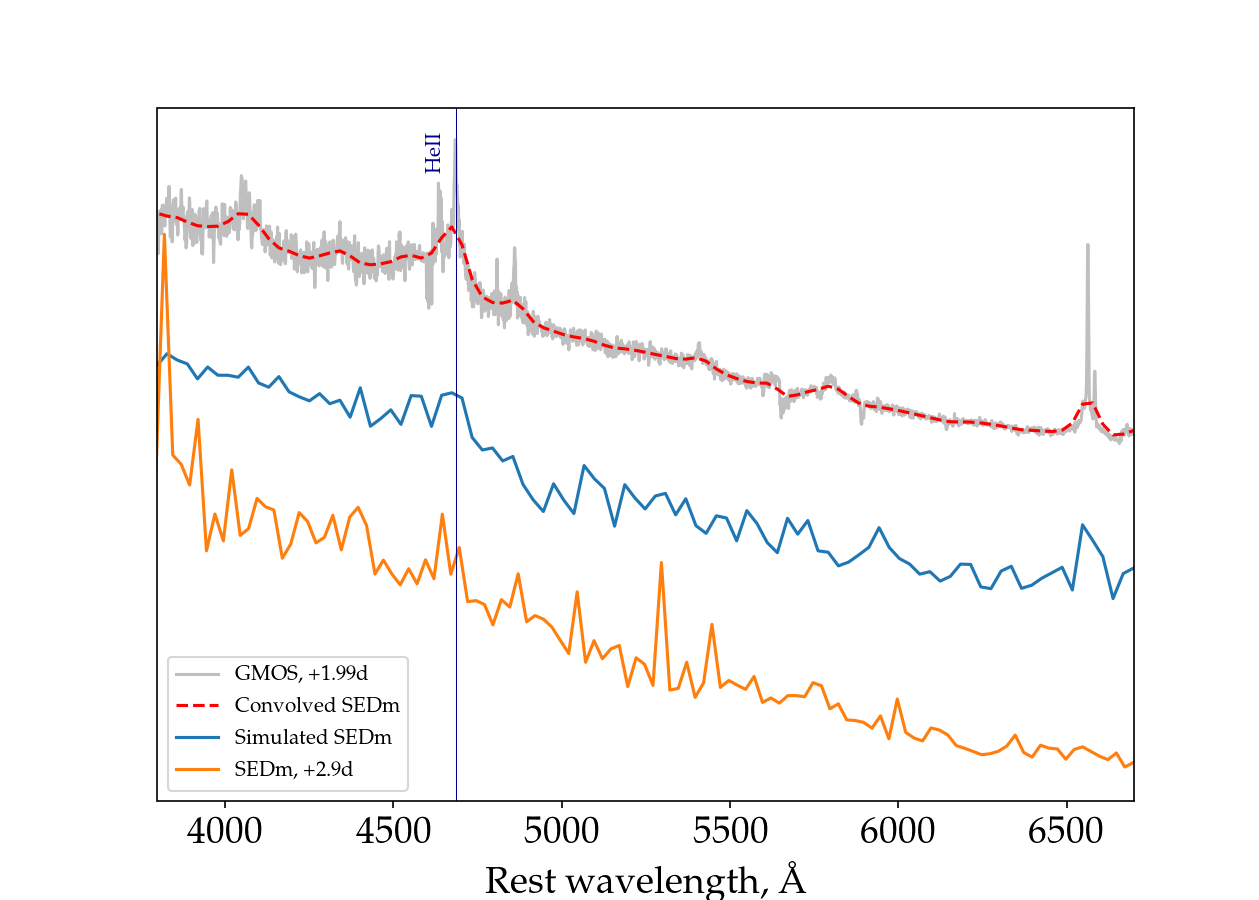

Text(0.5, 0, 'Rest wavelength, Å')

In [516]:

norma_real_sedm = np.median(real_sedm_urj[(real_sedm_urj['wl']>4000)&(real_sedm_urj['wl']<5000)]['flux'])
norma_real_gem  = np.median(urj[(urj['wl']>4000)&(urj['wl']<5000)]['flux'])

plt.figure(figsize = (6*1.4,6))
# plt.title('Redshift corrected, ISM redd corrected')
plt.plot(urj['wl'], urj['flux']/norma_real_gem, alpha = 0.5, color = 'grey', label = 'GMOS, +1.99d')
plt.plot(binned_sedm['bin_wl'], binned_sedm['bin_flux']/norma_real_gem, ls = '--', color = 'red', label = 'Convolved SEDm')

plt.plot(binned_sedm['bin_wl'], binned_sedm['noised_flux']/norma_real_gem- 0.5, label = 'Simulated SEDm')

plt.plot(real_sedm_urj['wl'],  real_sedm_urj['flux']/norma_real_sedm -1, label = 'SEDm, +2.9d ')




plt.axvline(4686, color = 'darkblue', lw = 0.5) 
plt.text(4686-90, 1.3, 'HeII', color = 'darkblue', rotation = 90)

plt.xlim([3800,6700])
plt.ylim([-0.8,1.5])


plt.yticks([])
plt.legend()
plt.xlabel('Rest wavelength, Å', size = 18)

In [517]:
plt.savefig('/Users/r.saturn/PhD/WIP/Full_RISNeII_ZTF1/figures/flasher_statistics/19ust_sedmsim.pdf')

If we didn't have Gemini, we would'nt have caught it 

# ZTF19acignlo

In [457]:
nlo = ascii.read('/Volumes/Machiavelli/WIP/Full_Infant_SNeII/data/2019/ZTF19acignlo/spectroscopy/SN2019tjt_2019-10-31_02-19-27_VLT-UT1_FORS2_TNS.dat',
                              names = ['wl','flux'])
# urj['flux'] /= np.median(urj[(urj['wl']<6000)&(urj['wl']>5000)]['flux'])



In [458]:
nlo = correct_spectrum('ZTF19acignlo',nlo)

In [459]:
estimate_snr_over_band(nlo, bandpass=[4100,4500])

15.026155783947411

In [460]:

interp_flux = interp1d(nlo['wl'], nlo['flux'] ,  bounds_error=False, fill_value='nan')
interp_wl   = np.linspace(min(nlo['wl']), max(nlo['wl']), 4000)


In [461]:
sedm_nlo_sim = Table(data=([interp_wl,interp_flux(interp_wl)]), names = ('wl', 'flux'))

In [462]:
spek1   = pyasl.instrBroadGaussFast(sedm_nlo_sim['wl'], sedm_nlo_sim['flux'], 100, edgeHandling='firstlast', fullout=False, maxsig=None)
sedm_nlo_sim['convSEDm']  = spek1


binned_sedm    = bin_spectra(sedm_nlo_sim['wl'],sedm_nlo_sim['convSEDm'], 30 )

187
the spectra is binned for a resolution of 30


In [468]:
noised_flux_Sedm = noise_spec(snr = 15, spec = binned_sedm, bandpass=[4100,4500])
binned_sedm['noised_flux'] = noised_flux_Sedm

In [467]:
# var_sedmsim       = np.var(binned_sedm[(binned_sedm['bin_wl']>=4100)&(binned_sedm['bin_wl']<=4500)]['bin_flux'])

# test_snr_sedm_sim = binned_sedm[(binned_sedm['bin_wl']>=4100)&(binned_sedm['bin_wl']<=4500)]

# sedm_nlo_sim   = np.nanmedian(binned_sedm['bin_flux']/np.sqrt(var_sedmsim))

# sedm_nlo_sim


In [470]:

var_sedmsim       = np.var(binned_sedm[(binned_sedm['bin_wl']>=4100)&(binned_sedm['bin_wl']<=4500)]['noised_flux'])

test_snr_sedm_sim = binned_sedm[(binned_sedm['bin_wl']>=4100)&(binned_sedm['bin_wl']<=4500)]

sedm_nlo_sim   = np.nanmedian(test_snr_sedm_sim['noised_flux']/np.sqrt(var_sedmsim))

sedm_nlo_sim

11.391286840749899

In [471]:

real_sedm_nlo = ascii.read('/Volumes/Machiavelli/WIP/Full_Infant_SNeII/data/2019/ZTF19acignlo/spectroscopy/ZTF19acignlo_20191030_P60_v2.ascii',
                          names = ['wl','flux','var'])

real_sedm_nlo = correct_spectrum('ZTF19acignlo',real_sedm_nlo)

var     = np.var(real_sedm_nlo[(real_sedm_nlo['wl']>=4100)&(real_sedm_nlo['wl']<=4500)]['flux'])

test_snr = real_sedm_nlo[(real_sedm_nlo['wl']>=4100)&(real_sedm_nlo['wl']<=4500)]

nlo_snr = np.nanmedian(test_snr['flux']/np.sqrt(var))
nlo_snr

9.46316444326823

<IPython.core.display.Javascript object>


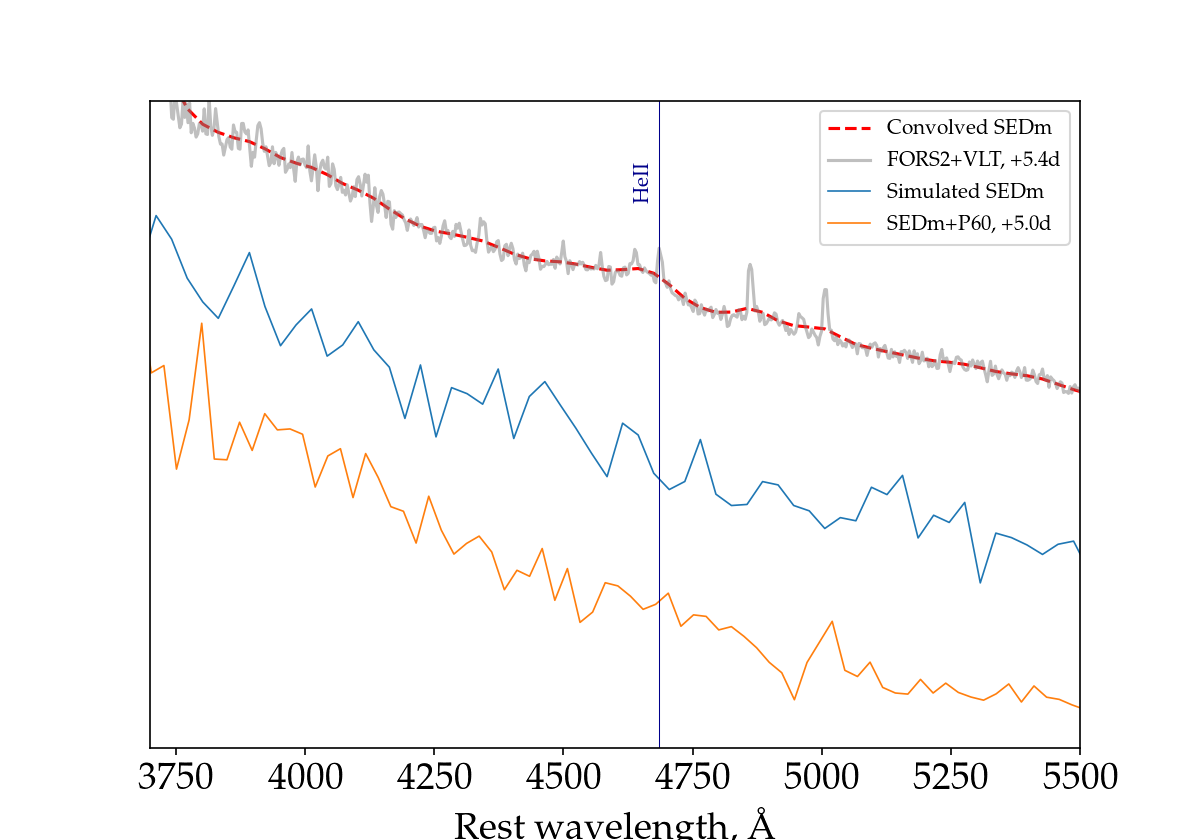

(-0.5, 1.5)

In [493]:

norma_real_sedm = np.median(real_sedm_nlo[(real_sedm_nlo['wl']>4000)&(real_sedm_nlo['wl']<5000)]['flux'])
norma_real_gem  = np.median(nlo[(nlo['wl']>4000)&(nlo['wl']<5000)]['flux'])

plt.figure()
# plt.title('Redshift corrected, ISM redd corrected')
plt.plot(binned_sedm['bin_wl'], binned_sedm['bin_flux']/norma_real_gem, ls = '--', color = 'red', label = 'Convolved SEDm')
plt.plot(nlo['wl'], nlo['flux']/norma_real_gem, alpha = 0.5, color = 'grey', label = 'FORS2+VLT, +5.4d')


plt.plot(binned_sedm['bin_wl'], binned_sedm['noised_flux']/norma_real_gem - 0.5, lw = 0.8, label = 'Simulated SEDm')

plt.plot(real_sedm_nlo['wl'],  real_sedm_nlo['flux']/norma_real_sedm -1,lw = 0.8 , label = 'SEDm+P60, +5.0d')

# plt.fill_between(spec['wl'], 
#                  spec['flux'] + np.sqrt(spec['var']),
#                  spec['flux'] - np.sqrt(spec['var']), 
#                  alpha=0.5, color=h[0].get_color())
# plt.axvline(4861, color = 'red' ) 
# plt.text(4861+10, 1.7, r'H $\beta$', color = 'red')

plt.axvline(4686, color = 'darkblue', lw = 0.5) 
plt.text(4686-50, 1.2, 'HeII', color = 'darkblue', rotation = 90)

# plt.ylim([-0.5e-17,3e-17])

plt.yticks([])
plt.legend()
plt.xlabel('Rest wavelength, Å', size = 18)

plt.xlim([3700,5500])
plt.ylim([-0.5,1.5])

In [494]:
plt.savefig('/Users/r.saturn/PhD/WIP/Full_RISNeII_ZTF1/figures/flasher_statistics/19tjt_sedmsim.pdf')

# Figuring out some PyASL functions for estimating SNR and intrinsic noise


What we're learning here is that the noise is 1/SNR ? 

In [284]:
from __future__ import print_function
from PyAstronomy import pyasl
import numpy as np

# Set up artificial data set
x = np.linspace(0., 1., 200)
y = 10.2 + x + 4 * x**2
# Add some independent, Gaussian noise
gstd = 0.1
y += np.random.normal(0., gstd, len(x))

# Estimate noise using robust estimate
beq = pyasl.BSEqSamp()
# Define order of approximation (use larger values such as 2,3, or 4 for
# faster varying or less well sampled data sets; also 0 is a valid order)
N = 1
# Define 'jump parameter' (use larger values such as 2,3, or 4 if correlation
# between adjacent data point is suspected)
j = 1
# Estimate noise assuming equidistant sampling (often a good approximation even
# if data are not strictly equidistant) and robust estimation (often advantageous
# in working with real data)
nstd, nstdstd = beq.betaSigma(y, N, j, returnMAD=True)

print("Input noise std: ", gstd)
print("Estimated noise std = %5.3f +/- %5.3f" % (nstd, nstdstd))

Input noise std:  0.1
Estimated noise std = 0.097 +/- 0.011


In [303]:
# Estimate noise using robust estimate
beq = pyasl.BSEqSamp()
# Define order of approximation (use larger values such as 2,3, or 4 for
# faster varying or less well sampled data sets; also 0 is a valid order)
N = 1
# Define 'jump parameter' (use larger values such as 2,3, or 4 if correlation
# between adjacent data point is suspected)
j = 1
# Estimate noise assuming equidistant sampling (often a good approximation even
# if data are not strictly equidistant) and robust estimation (often advantageous
# in working with real data)
nstd, nstdstd = beq.betaSigma(binned_sedm['bin_flux'], N, j, returnMAD=True)


# print("Estimated noise std = % +/- %" % (nstd, nstdstd))

In [304]:
nstd

1.0615097813215315e-18

In [305]:
# Estimate noise using robust estimate
beq = pyasl.BSEqSamp()
# Define order of approximation (use larger values such as 2,3, or 4 for
# faster varying or less well sampled data sets; also 0 is a valid order)
N = 1
# Define 'jump parameter' (use larger values such as 2,3, or 4 if correlation
# between adjacent data point is suspected)
j = 1
# Estimate noise assuming equidistant sampling (often a good approximation even
# if data are not strictly equidistant) and robust estimation (often advantageous
# in working with real data)
nstd, nstdstd = beq.betaSigma(urj['flux'], N, j, returnMAD=True)

nstd

2.3484469060342377e-18

In [340]:

# Number of data points
N = 10000
# Signal to noise ratio
SNR = 50.0

# Create some data with noise and a sinusoidal
# variation.
x  = np.arange(N)
y  = np.random.normal(0.0, 1.0/SNR, N) 
y1 = np.sin(x/500.0*2.*np.pi)*0.1 + 1 ### WHY do you need to decenter it from zero? 
y2 = y1+y


In [345]:
N = 2
# Define 'jump parameter' (use larger values such as 2,3, or 4 if correlation
# between adjacent data point is suspected)
j = 1
# Estimate noise assuming equidistant sampling (often a good approximation even
# if data are not strictly equidistant) and robust estimation (often advantageous
# in working with real data)
nstd, nstdstd = beq.betaSigma(y2, N, j, returnMAD=True)

In [347]:
1/nstd

50.47366387448815

<IPython.core.display.Javascript object>


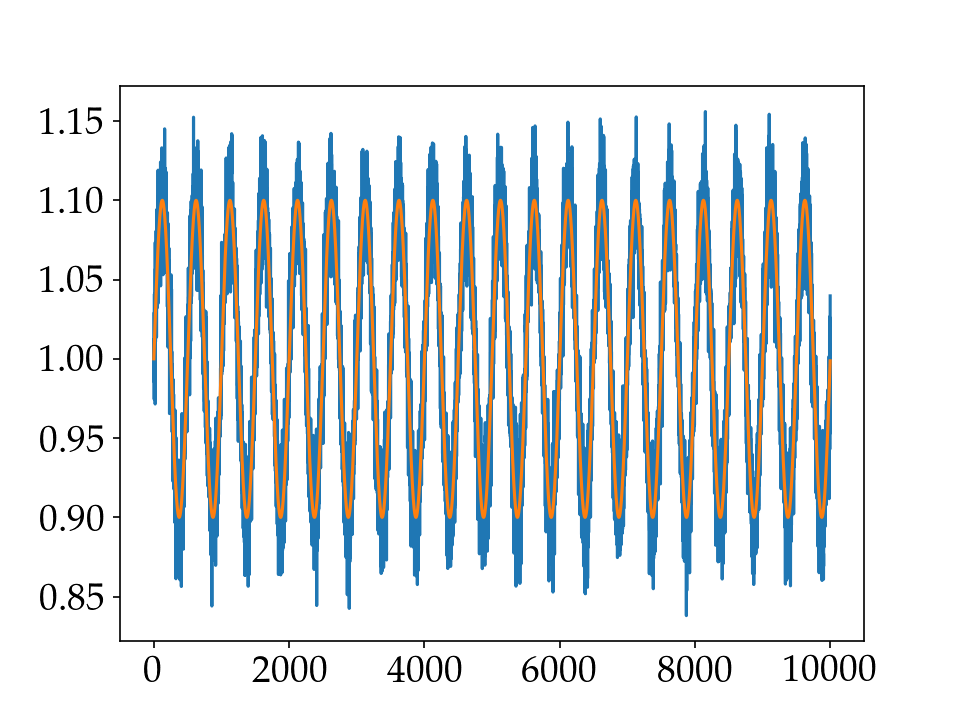

In [334]:
plt.figure()

plt.plot(x,y2)
plt.plot(x,y1)

In [1]:
# plt.figure()
# Estimate the signal to noise ratio. Check whether the
# estimate fits the input...
# Use a chunk length of 20 data points, a polynomial of degree
# one, and produce a "control plot".
# snrEsti = pyasl.estimateSNR(x, y2, 20, deg=1, controlPlot=True)
# print("Estimate of the SNR: ", snrEsti["SNR-Estimate"])



In [2]:
# plt.figure()
# Estimate the signal to noise ratio. Check whether the
# estimate fits the input...
# Use a chunk length of 20 data points, a polynomial of degree
# one, and produce a "control plot".
# snrEsti = pyasl.estimateSNR(x, y2, 20, deg=1, controlPlot=True)
# print("Estimate of the SNR: ", snrEsti["SNR-Estimate"])



## CHECKING SEDM SPEC LIVE 

In [9]:
ls

22jww_1405.ascii
Spectroscopic Analysis 2d Subsample.ipynb
ZTF18abojpnr/
ZTF18acqwdla/
ZTF19aarfkch/
ZTF19aatqzrb/
ZTF19abbwfgp/
ZTF19abpidqn/
ZTF19abrlvij/
ZTF19acctwpz/
ZTF20aasfhia/
ZTF20abybeex/
ZTF20acknpig/
ZTF20acuaqlf/
ZTF20acwgxhk/
__pycache__/
blablajwww.ascii
cadia.ascii
fitter_full_code_def.py
hgspec_targetsnonly_crr_b_ifu20220425_11_13_21_ZTF22aahhgjh.txt
lines_library.py
main.py


In [10]:
spec = ascii.read('cadia.ascii',
                              names = ['wl','flux','var'])

In [11]:
spec['wl'] /= (1+0.0029)

In [18]:
pigsnr = estimate_snr_over_band(spec, bandpass=[5900,6300], is_var = False)
pigsnr

17.35428435934192

In [19]:
pigsnr = estimate_snr_over_band(spec, bandpass=[3800,4100], is_var = True)
pigsnr

2.528995030177029

<IPython.core.display.Javascript object>


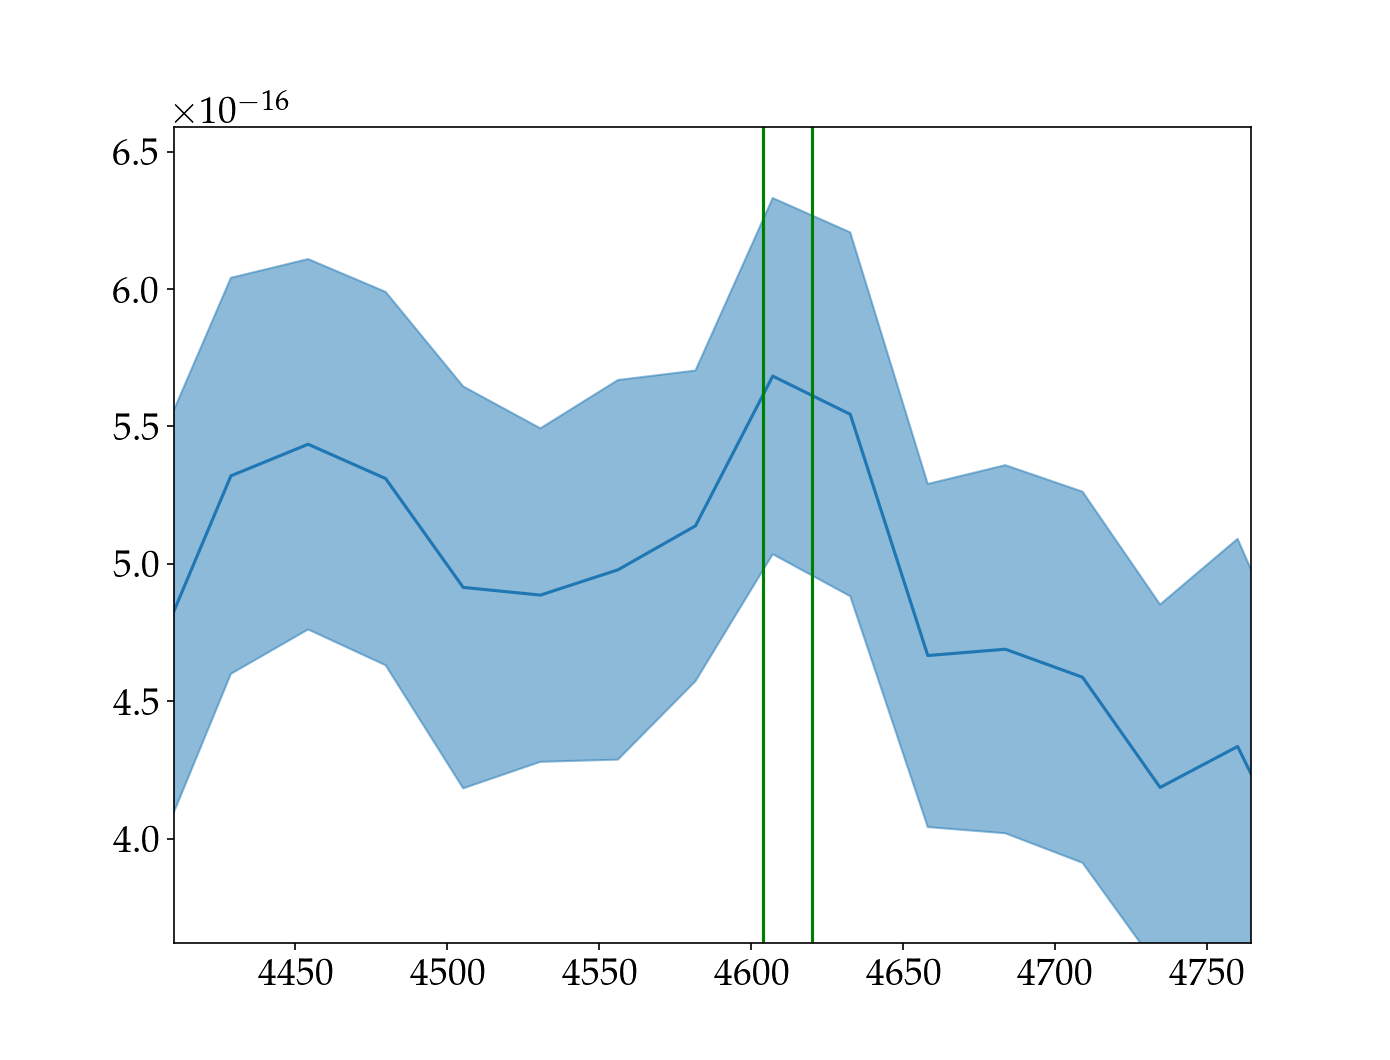

Text(4536, 1e-16, 'N V')

In [20]:

plt.figure()
# plt.title('Redshift corrected, ISM redd corrected')
h = plt.plot(spec['wl'], spec['flux'])
plt.fill_between(spec['wl'], 
                 spec['flux'] + np.sqrt(spec['var']),
                 spec['flux'] - np.sqrt(spec['var']), 
                 alpha=0.5, color=h[0].get_color())
plt.axvline(4861, color = 'red' ) 
plt.text(4861+10, 1e-16, r'H $\beta$', color = 'red')
# plt.axvline(4686, color = 'darkblue') 
plt.axvline(6563, color = 'red') 


plt.axvline(4620, color = 'green') 
plt.axvline(4604, color = 'green') 
plt.text(6563+10, 2e-16, r'H $\alpha$', color = 'red')
plt.text(4686-150, 1e-16, 'N V', color = 'green', rotation = 90)
